In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(plt.get_backend())
import datetime as dtm
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import r2_score,explained_variance_score,mean_squared_error,mean_absolute_error,confusion_matrix
from sklearn.linear_model import LassoCV,LinearRegression
import xgboost as xgb
plt.rcParams['font.sans-serif']=[u'SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
#显示所有列
#pd.set_option('display.max_columns', None)
#显示所有行
#pd.set_option('display.max_rows', None)
from config.base_config import * 
from config.models import *  #循环调用不同模型
from config.model_config import * #几种模型的名称、参数设置
from config.data_process_before_model import * #把数据划分为训练和测试，并把训练数据化为x和y
from config.evaluation import * ##模型评估

module://ipykernel.pylab.backend_inline


In [2]:
# GET multi_para OBS DATA 包含了所有国内站点的观测数据
obs_txt_path='/home/liuli/GTS_GFS_MOS/domestic_hourly_data/'
file1= pd.read_csv(obs_txt_path+'df_t2m.csv',sep=',')
df1=pd.DataFrame(file1)
df1['time']=pd.DatetimeIndex(df1['time'])
print(df1.info()) #300站点，每天8个时次，365天，共（8*365+1）*300=876300行
# get the station information
#file2= pd.read_csv(obs_txt_path+'6-para-station-info-t2m.txt', header=None, sep='\t', names=['id','lat','lon'])
#df2=pd.DataFrame(file2)
#SID_TODO=list(df2['id'].astype('str'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876300 entries, 0 to 876299
Data columns (total 5 columns):
time    876300 non-null datetime64[ns]
sta     876300 non-null int64
lat     868800 non-null float64
lon     868800 non-null float64
t2m     868800 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 33.4 MB
None


In [3]:
# Integrate the features into one file
def make_feature_target(id):    
    """
    This function is used for integrateing the splited feature files into a big one 
    and retrive the target data
    """ 
    ###first we should judge if the file exist
    count=0
    for aa in range(1,13):
        name_aa=id+'_multi_para_%02i.txt' % aa
        if os.path.exists(fea_txt_path+'/'+name_aa):
            count=count+1
    if count==12:
        print("%s target data is complete, now we will training the %s " % (id,id) )
        df_feature=pd.DataFrame(columns=feature_cols)
        for cc in range(1,13):
            name=id+'_multi_para_%02i.txt' % cc                
            file_tmp= pd.read_csv(fea_txt_path+'/'+name, header=None, sep=' \\s+',names=feature_cols)
            df_tmp=pd.DataFrame(file_tmp)
            df_feature=pd.concat([df_feature,df_tmp],ignore_index=True) 
        start='2018-01-01 00:00:00'
        end_of_db = '2019-01-01 00:00:00'
        date_index = pd.date_range(start, end_of_db, freq = '3h')
        date_df = pd.DataFrame(date_index,columns=['time'])
        df_feature.insert(0,'time', date_df )#插入时间作为标记 
        
        df_target=df1[df1['sta'].isin([id])] #先挑出这个要素
        df_target=df_target.sort_values(by='time')
        df_target=df_target.reset_index(drop=True) 
        #print(df_target)
        df_ready = pd.merge(df_feature,df_target, on=['time'], how='left')
        return df_ready
    else:
        print("%s target data is not complete !" % id)
        return None
    
#for i_sid in SID_TODO:
#    print("%s processing..." % i_sid) 
#    # for each station ,there are 12 multi_para and 12 rain files
#    df_ready=make_feature_target(i_sid)
#    print(df_ready)

In [4]:
def func_get_eval_df(df, model_out, target='TARGET',baseline=False,model_name=None,sid=None):
    """
    merge target and prediction into one dataframe
    """
    index_col_0 = ['time']
#    if 'SID' in df.columns:
#        index_col_0 = ['SID', 'datetime', 'datetime0']
#    else:
#        index_col_0 = ['datetime', 'datetime0']

    X, y, _, index_remain, y_baseline = prepare_training_data(
        df, target=target, index_col=index_col_0)
    
    y_pred = model_out.predict(X)
    y_arr = np.hstack((y.reshape(-1, 1), y_pred.reshape(-1, 1)))
    df_pred = pd.DataFrame(
        y_arr, index=index_remain, columns=['TARGET', model_name])
    df_pred = df_pred.reset_index()
    col_nm_lst = index_col_0 + ['TARGET', model_name]
    df_pred.columns = col_nm_lst
    ###output target-pre-base
    if baseline==True:
        print("start to output the curve data including target, our_fcst, and GFS")
        y_arr_out = np.hstack((y.reshape(-1, 1), y_pred.reshape(-1, 1),y_baseline.reshape(-1,1)))
        df_out = pd.DataFrame(y_arr_out, index=index_remain, columns=['TARGET', model_name,'GFS'])
        df_out = df_out.reset_index()
        col_nm_lst_out = index_col_0 + ['TARGET', model_name,'GFS']
        df_out.columns = col_nm_lst_out
        df_out.to_csv(sid+'_'+model_name+'_curve_data.csv',sep=',') 
        del df_out        
    ###make another df including target and base to be evaluated
        y_arr_base = np.hstack((y.reshape(-1, 1),y_baseline.reshape(-1,1)))
        df_base = pd.DataFrame(y_arr_base, index=index_remain, columns=['TARGET','GFS'])
        df_base = df_base.reset_index()
        col_nm_lst_base = index_col_0 + ['TARGET', 'GFS']
        df_base.columns = col_nm_lst_base
        return df_pred,df_base
    return df_pred

In [5]:
def func_training_flow(X_train, y_train, features,X_test,X_train_stack,X_test_stack,df_dev,clfs,
                       icount=None,
                       df_test=None,
                       target='TARGET',
                       sid='sid_test',
                       model_config=None,
                       pkl_model=False,
                       model_dir=MODEL_DIR,
                       gs=False,
                       param_grid=None,
                       rs=False,
                       param_dist=None,
                       printing=True,
                       plotting=True,
                       train_all=True,
                       baseline=False):
    #print("icount",icount)
    model_name = model_config[0]
    model_param = model_config[-1]
    print("###### Training with %s ######" % model_name)
    if gs:
        print("##### Training with grid_search. #####")
    else:
        print("###### Params are: ######")
        print(model_param)

    print(">>>>> MODEL FLOW <<<<<")
    #from mos_base.models import *  #循环调用不同模型
    model_out = func_model_flow(
        X_train,
        y_train,
        model_name=model_name,
        model_param=model_param,
        columns=features,
        gs=gs,
        param_grid=param_grid,
        rs=rs,
        param_dist=param_dist,
        printing=printing,
        plotting=plotting)
    print(">>>>> MODEL STACK <<<<<")#为后续的模型stack做准备，先把每个模型的结果准备好

    n_folds = 10
    skf = KFold(n_splits=n_folds, shuffle=False, random_state=1)
    X_stack_test_n = np.zeros((X_test.shape[0], n_folds)) #存储测试数据，最后需要把它作平均
    for j,(train_index,test_index) in enumerate(skf.split(X_train,y_train)):
        print(model_name,"folder time:  ",j)
        tr_x = X_train[train_index]
        #print("tr_x.shape",tr_x.shape)
        tr_y = y_train[train_index]
        #print(tr_y.shape)
        model_out_fold = func_model_flow(
                                    tr_x,
                                    tr_y,
                                    model_name=model_name,
                                    model_param=model_param,
                                    columns=features,
                                    gs=gs,
                                    param_grid=param_grid,
                                    rs=rs,
                                    param_dist=param_dist,
                                    printing=False,
                                    plotting=False)
        #生成stacking训练数据集
        X_train_stack [test_index, icount] =  model_out_fold.predict(X_train[test_index])       
        X_stack_test_n[:,j] = model_out_fold.predict(X_test)
    #生成stacking测试数据集
    X_test_stack[:, icount] = X_stack_test_n.mean(axis=1)
    if icount==(len(clfs)-1): #最后一个模型算完后，开始进行stack第二层步骤
        clf_second = lgb.LGBMRegressor()
        clf_second.fit(X_train_stack,y_train)
        pred_stack = clf_second.predict(X_test_stack)

    if pkl_model:
        model_nm = "%s_%s.model" % (sid, model_name)
        pkl_file_path = os.path.join(model_dir, model_nm)
        print("========== Dumping Models ==========")
        with open(pkl_file_path, 'wb') as file:
            pickle.dump(model_out, file)
        print(">>>>>>>>>> Finished !! <<<<<<<<<<")

    if train_all:
        return None, None
    else:
        if baseline==True:
            df_pred_dev,df_base= func_get_eval_df(df_dev, model_out, target=target,baseline=baseline,
                                                  model_name=model_name,sid=sid)
            if icount==(len(clfs)-1):
                return df_pred_dev,df_base,pred_stack
            else:
                return df_pred_dev,df_base  #return a df including target and predictions
        else:
            df_pred_dev= func_get_eval_df(df_dev, model_out, target=target,baseline=baseline,
                                          model_name=model_name,sid=sid)
            return df_pred_dev  #return a df including target and predictions
        
        
#        df_pred_test = None
#        if isinstance(df_test, pd.DataFrame):
#            df_pred_test = func_get_eval_df(df_test, model_out, target=target)
#        return df_pred_dev, df_pred_test
    



In [6]:
def running_training(df_feature_ready,
                     clfs,
                     sid,
                     target='TARGET',
                     pkl_model=True,
                     model_dir=MODEL_DIR,
                     plotting=False,
                     printing=False,
                     train_all=False,
                     baseline=False):

    result_metrics = {}
    result_metrics_base = {}
    ##先把数据做好处理，再开始调用模型
    if train_all:
        df_train = df_feature_ready
        X_train, y_train, features,_, _ = prepare_training_data(df_train, target=target, index_col=index_col_0, date_col='time')
    else:
        # df_train, df_dev = train_test_df_spilt(df_0, ratio=0.7)
        df_train, df_dev = train_test_df_spilt(
            df_feature_ready,
            ts='2018-11-01 00:00:00',
            is_start=True,
            date_col='time',
            ratio=0.8,
            split_method='r')
        index_col_0 = ['time']
    ###主要是把dataframe分开成输入和target
        X_test, _, _, _, _ = prepare_training_data(df_dev, target=target, index_col=index_col_0, date_col='time')
    #X_train写在if外面照顾train_all的情况    
        X_train, y_train, features, _, _ = prepare_training_data(df_train, target=target, index_col=index_col_0, date_col='time')
        #############这里开始要stack操作
        X_train_stack  = np.zeros((X_train.shape[0], len(clfs)))  #这里的5指的是下面的5个模型，X_train_stack和X_test_stack是给stack准备用的np
        X_test_stack = np.zeros((X_test.shape[0], len(clfs)))
    
#    dict_all_model_df = {}
#    for model_i in [lgbm_config, et_config, xgb_config,  rf_config, cat_config]: ###ANN和SVR效果太差了，舍弃
    
    for icount,model_i in enumerate(clfs): ###ANN和SVR效果太差了，舍弃
#    for model_i in [lgbm_config,et_config]:
#        print( "train_all", train_all)
        if baseline==True:
            if icount==(len(clfs)-1):
                df_pred,df_base,pred_stack = func_training_flow(
                                             X_train, y_train, features,X_test, X_train_stack,X_test_stack,df_dev,clfs,
                                            icount,
                                            sid=sid,
                                            pkl_model=pkl_model,
                                            model_dir=model_dir,
                                            model_config=model_i,
                                            plotting=plotting,
                                            printing=printing,
                                            train_all=train_all,
                                            baseline=baseline,
                                            target=target)
            else:
                df_pred,df_base = func_training_flow(
                                            X_train, y_train, features,X_test,X_train_stack,X_test_stack,df_dev,clfs,
                                            icount,
                                            sid=sid,
                                            pkl_model=pkl_model,
                                            model_dir=model_dir,
                                            model_config=model_i,
                                            plotting=plotting,
                                            printing=printing,
                                            train_all=train_all,
                                            baseline=baseline,
                                            target=target)
        else:
            df_pred = func_training_flow(
            X_train, y_train, features,X_test,X_train_stack,X_test_stack,df_dev,clfs,
            icount,
            sid=sid,
            pkl_model=pkl_model,
            model_dir=model_dir,
            model_config=model_i,
            plotting=plotting,
            printing=printing,
            train_all=train_all,
            baseline=baseline,
            target=target)

        if train_all:
            continue
        else:
            print("start to evaluate")
            metrics_i = func_evaluation(df_pred['TARGET'], df_pred[model_i[0]])
            result_metrics[model_i[0]] = metrics_i
            
#            if sid == 'ALL_SITES':
#                dict_all_model_df[model_i[0]] = df_pred
        
    if train_all: 
        return None,None
    else:
        if baseline==True:
        #print(result_metrics)
            metrics_i_2 = func_evaluation(df_base['TARGET'], df_base['GFS'])
            result_metrics['baseline'] = metrics_i_2
            if icount==(len(clfs)-1):
                metrics_i_3 = func_evaluation(df_base['TARGET'], pred_stack)
                result_metrics['stack'] = metrics_i_3
            
            df_result_metrics = get_result_df(result_metrics)
            #df_result_metrics_base = get_result_df(result_metrics_base) 
#            return df_result_metrics,result_metrics_base
        else:
            df_result_metrics = get_result_df(result_metrics)
        return df_result_metrics

In [7]:
#training
def train_by_site(train_all=False,baseline=False,target='TARGET'):
    """
    This function is used for training models SITE BY SITE, with their own feature csv.
    """
    if train_all:
        pkl_model = True
        plotting = False
    else:
        pkl_model = False #是否保存模型结构
        plotting = True #是否画出feature的重要性
            
    dict_result_metrics = {}
    dict_result_metrics_base = {}
    
    clfs=[lgbm_config, et_config, xgb_config,  rf_config, cat_config]
    #clfs=[lgbm_config]
    for i_sid in SID_TODO:
        print("%s processing..." % i_sid)
        #首先读取特征和目标数据
        df_ready=make_feature_target(i_sid)
        #df_ready.to_csv('df_ready.csv',sep=',')
        if df_ready is None:
            continue
        #print(df_ready)
        #开始跑模型

        df_result_metrics= running_training(
            df_ready,
            clfs,
            sid=i_sid,
            pkl_model=pkl_model,
            model_dir=MODEL_DIR,
            plotting=plotting,
            printing=True,
            train_all=train_all,
            baseline=baseline,
            target=target)        
        dict_result_metrics[i_sid] = df_result_metrics
        df_result_metrics.to_csv(i_sid+'_result_pre_base.csv',sep=',')
    return dict_result_metrics

In [8]:
#training
def train_all_site(train_all=False):
    """
    This function is used for training models  BY ALL SITES.
    """
    if train_all:
        pkl_model = True
        plotting = False
    else:
        pkl_model = False #是否保存模型结构
        plotting = True #是否画出feature的重要性
        
    dict_result_metrics = {}
    df_all=pd.DataFrame(columns=feature_cols)
    
    for i_sid in SID_TODO:
        print("%s processing..." % i_sid)
        #首先读取特征和目标数据
        df_ready=make_feature_target(i_sid)
        df_all=pd.concat([df_all,df_ready],ignore_index=True)
        #开始跑模型
    #print(df_all)
    df_result_metrics= running_training(
            df_all,
            sid=i_sid,
            pkl_model=pkl_model,
            model_dir=MODEL_DIR,
            plotting=plotting,
            printing=True,
            train_all=train_all)
        
    dict_result_metrics= df_result_metrics

    return dict_result_metrics

In [9]:
#training
def train_ready_df(train_all=False):
    """
    This function is used for training models  with a ready dataframe including target and .
    """
    if train_all:
        pkl_model = True
        plotting = False
    else:
        pkl_model = False #是否保存模型结构
        plotting = True #是否画出feature的重要性
        
    dict_result_metrics = {}
    file_temp= pd.read_csv('/home/liuli/GTS_GFS_MOS/domestic_hourly_data/2287.csv',sep=',')
    df_all=pd.DataFrame(file_temp)
    #print(df_all)
        #开始跑模型
    i_sid="test"
    df_result_metrics= running_training(
            df_all,
            sid=i_sid,
            pkl_model=pkl_model,
            model_dir=MODEL_DIR,
            plotting=plotting,
            printing=True,
            train_all=train_all)
        
    dict_result_metrics= df_result_metrics

    return dict_result_metrics

['52884']
52884 processing...
52884 target data is complete, now we will training the 52884 


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/ipykernel_launcher.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


df.shape: (2920, 69)
Training set size:  (2336, 69)
Test set size:  (584, 69)
Current dataset time range:  2018-10-20 00:00:00  ===>  2018-12-31 21:00:00
Current dataset size:  (584, 69)
Prediction target: ['t2m']
##### FEATURES and their Sequence: #####
['vis', 'sp', 'oro', 'hpb', 't0', 'slp', 'u10', 'v10', 'wdir10', 'wspd10', 'u80', 'v80', 'wdir80', 'wspd80', 'p80', 'q80', 't80', 'q', 'd2', 'r2', 't2', 'u2b', 'v2b', 'wdir2b', 'wspd2b', 'g2b', 't2b', 'r2b', 'u5b', 'v5b', 'wdir5b', 'wspd5b', 'g5b', 't5b', 'r5b', 'u8b', 'v8b', 'wdir8b', 'wspd8b', 'g8b', 't8b', 'r8b', 'u9b', 'v9b', 'wdir9b', 'wspd9b', 'g9b', 't9b', 'r9b', 'u1k', 'v1k', 'wdir1k', 'wspd1k', 'g1k', 't1k', 'r1k', 'tsig', 'ptsig', 'rsig', 'usig', 'vsig', 'wdirs', 'wspds', 'wsig', 'sta', 'lat', 'lon']
Current dataset time range:  2018-01-01 00:00:00  ===>  2018-10-19 21:00:00
Current dataset size:  (2336, 69)
Prediction target: ['t2m']
##### FEATURES and their Sequence: #####
['vis', 'sp', 'oro', 'hpb', 't0', 'slp', 'u10', 'v1

LGBM folder time:   7
###### Training with LGBM without param-tuning ######
###### Params are: ######
{'learning_rate': 0.01, 'seed': 2019, 'colsample_bytree': 0.8, 'reg_alpha': 12.99, 'max_bin': 680, 'metric': 'l2_root', 'n_estimators': 1000, 'min_split_gain': 0, 'n_jobs': -1, 'num_leaves': 179, 'subsample': 0.7, 'reg_lambda': 33}
####################！！！LightGBM Running！！！##########################
LGBM folder time:   8
###### Training with LGBM without param-tuning ######
###### Params are: ######
{'learning_rate': 0.01, 'seed': 2019, 'colsample_bytree': 0.8, 'reg_alpha': 12.99, 'max_bin': 680, 'metric': 'l2_root', 'n_estimators': 1000, 'min_split_gain': 0, 'n_jobs': -1, 'num_leaves': 179, 'subsample': 0.7, 'reg_lambda': 33}
####################！！！LightGBM Running！！！##########################
LGBM folder time:   9
###### Training with LGBM without param-tuning ######
###### Params are: ######
{'learning_rate': 0.01, 'seed': 2019, 'colsample_bytree': 0.8, 'reg_alpha': 12.99, 'max_bin'

/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 1) t1k                            0.215233
 2) t2                             0.160793
 3) ptsig                          0.157218
 4) t0                             0.144014
 5) t80                            0.131437
 6) t9b                            0.089557
 7) tsig                           0.026147
 8) hpb                            0.023214
 9) t8b                            0.007503
10) d2                             0.002277
11) g2b                            0.001858
12) t5b                            0.001655
13) r5b                            0.001575
14) wspd80                         0.001473
15) wspd1k                         0.001369
16) r2b                            0.001354
17) usig                           0.001231
18) u1k                            0.001204
19) wdir5b                         0.001203
20) u8b                            0.001153
21) t2b                            0.001145
22) wspd10                         0.001045
23) vis                         

/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ET folder time:   1
###### Training with ET without param-tuning ######
###### Params are: ######
{'criterion': 'mse', 'n_jobs': -1, 'random_state': 2019, 'max_depth': 10, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.95}
####################！！！ET Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ET folder time:   2
###### Training with ET without param-tuning ######
###### Params are: ######
{'criterion': 'mse', 'n_jobs': -1, 'random_state': 2019, 'max_depth': 10, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.95}
####################！！！ET Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ET folder time:   3
###### Training with ET without param-tuning ######
###### Params are: ######
{'criterion': 'mse', 'n_jobs': -1, 'random_state': 2019, 'max_depth': 10, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.95}
####################！！！ET Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ET folder time:   4
###### Training with ET without param-tuning ######
###### Params are: ######
{'criterion': 'mse', 'n_jobs': -1, 'random_state': 2019, 'max_depth': 10, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.95}
####################！！！ET Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ET folder time:   5
###### Training with ET without param-tuning ######
###### Params are: ######
{'criterion': 'mse', 'n_jobs': -1, 'random_state': 2019, 'max_depth': 10, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.95}
####################！！！ET Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ET folder time:   6
###### Training with ET without param-tuning ######
###### Params are: ######
{'criterion': 'mse', 'n_jobs': -1, 'random_state': 2019, 'max_depth': 10, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.95}
####################！！！ET Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ET folder time:   7
###### Training with ET without param-tuning ######
###### Params are: ######
{'criterion': 'mse', 'n_jobs': -1, 'random_state': 2019, 'max_depth': 10, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.95}
####################！！！ET Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ET folder time:   8
###### Training with ET without param-tuning ######
###### Params are: ######
{'criterion': 'mse', 'n_jobs': -1, 'random_state': 2019, 'max_depth': 10, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.95}
####################！！！ET Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ET folder time:   9
###### Training with ET without param-tuning ######
###### Params are: ######
{'criterion': 'mse', 'n_jobs': -1, 'random_state': 2019, 'max_depth': 10, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.95}
####################！！！ET Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Current dataset time range:  2018-10-20 00:00:00  ===>  2018-12-31 21:00:00
Current dataset size:  (584, 69)
Prediction target: ['t2m']
##### FEATURES and their Sequence: #####
['vis', 'sp', 'oro', 'hpb', 't0', 'slp', 'u10', 'v10', 'wdir10', 'wspd10', 'u80', 'v80', 'wdir80', 'wspd80', 'p80', 'q80', 't80', 'q', 'd2', 'r2', 't2', 'u2b', 'v2b', 'wdir2b', 'wspd2b', 'g2b', 't2b', 'r2b', 'u5b', 'v5b', 'wdir5b', 'wspd5b', 'g5b', 't5b', 'r5b', 'u8b', 'v8b', 'wdir8b', 'wspd8b', 'g8b', 't8b', 'r8b', 'u9b', 'v9b', 'wdir9b', 'wspd9b', 'g9b', 't9b', 'r9b', 'u1k', 'v1k', 'wdir1k', 'wspd1k', 'g1k', 't1k', 'r1k', 'tsig', 'ptsig', 'rsig', 'usig', 'vsig', 'wdirs', 'wspds', 'wsig', 'sta', 'lat', 'lon']
start to output the curve data including target, our_fcst, and GFS
start to evaluate
模型的评估结果:
PersonR: 0.931726 
RMSE: 2.696827 
R2: 0.865487 
Explained Variance: 0.866443 
MSE: 7.272874 
MAE: 1.979804 
MAPE: 0.862108
###### Training with XGB ######
###### Params are: ######
{'min_child_weight': 8, 'learni

XGB folder time:   8
###### Training with XGB without param-tuning ######
###### Params are: ######
{'min_child_weight': 8, 'learning_rate': 0.01, 'silent': 1, 'max_depth': 8, 'random_state': 2019, 'colsample_bytree': 0.9, 'lambda': 1.0, 'eval_metric': 'rmse', 'booster': 'gbtree', 'objective': 'reg:linear', 'n_estimators': 1000, 'n_jobs': -1, 'subsample': 0.9, 'gamma': 0.7}
####################！！！XGBoost Running！！！##########################
XGB folder time:   9
###### Training with XGB without param-tuning ######
###### Params are: ######
{'min_child_weight': 8, 'learning_rate': 0.01, 'silent': 1, 'max_depth': 8, 'random_state': 2019, 'colsample_bytree': 0.9, 'lambda': 1.0, 'eval_metric': 'rmse', 'booster': 'gbtree', 'objective': 'reg:linear', 'n_estimators': 1000, 'n_jobs': -1, 'subsample': 0.9, 'gamma': 0.7}
####################！！！XGBoost Running！！！##########################
Current dataset time range:  2018-10-20 00:00:00  ===>  2018-12-31 21:00:00
Current dataset size:  (584, 69)
P

/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 1) t0                             0.755713
 2) t2                             0.186782
 3) hpb                            0.012833
 4) u8b                            0.002933
 5) wspd80                         0.002189
 6) t5b                            0.002026
 7) g2b                            0.001994
 8) r5b                            0.001948
 9) t2b                            0.001539
10) r2b                            0.001495
11) slp                            0.001336
12) v5b                            0.001298
13) tsig                           0.001216
14) v2b                            0.001178
15) wdir2b                         0.001150
16) g5b                            0.001104
17) u80                            0.001100
18) wspd2b                         0.001068
19) wspd10                         0.000980
20) d2                             0.000956
21) u10                            0.000921
22) r8b                            0.000827
23) wsig                        

/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF folder time:   1
###### Training with RF without param-tuning ######
###### Params are: ######
{'n_jobs': -1, 'oob_score': True, 'n_estimators': 1000, 'max_depth': 10, 'random_state': 2019, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.8}
####################！！！RF Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF folder time:   2
###### Training with RF without param-tuning ######
###### Params are: ######
{'n_jobs': -1, 'oob_score': True, 'n_estimators': 1000, 'max_depth': 10, 'random_state': 2019, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.8}
####################！！！RF Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF folder time:   3
###### Training with RF without param-tuning ######
###### Params are: ######
{'n_jobs': -1, 'oob_score': True, 'n_estimators': 1000, 'max_depth': 10, 'random_state': 2019, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.8}
####################！！！RF Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF folder time:   4
###### Training with RF without param-tuning ######
###### Params are: ######
{'n_jobs': -1, 'oob_score': True, 'n_estimators': 1000, 'max_depth': 10, 'random_state': 2019, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.8}
####################！！！RF Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF folder time:   5
###### Training with RF without param-tuning ######
###### Params are: ######
{'n_jobs': -1, 'oob_score': True, 'n_estimators': 1000, 'max_depth': 10, 'random_state': 2019, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.8}
####################！！！RF Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF folder time:   6
###### Training with RF without param-tuning ######
###### Params are: ######
{'n_jobs': -1, 'oob_score': True, 'n_estimators': 1000, 'max_depth': 10, 'random_state': 2019, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.8}
####################！！！RF Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF folder time:   7
###### Training with RF without param-tuning ######
###### Params are: ######
{'n_jobs': -1, 'oob_score': True, 'n_estimators': 1000, 'max_depth': 10, 'random_state': 2019, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.8}
####################！！！RF Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF folder time:   8
###### Training with RF without param-tuning ######
###### Params are: ######
{'n_jobs': -1, 'oob_score': True, 'n_estimators': 1000, 'max_depth': 10, 'random_state': 2019, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.8}
####################！！！RF Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF folder time:   9
###### Training with RF without param-tuning ######
###### Params are: ######
{'n_jobs': -1, 'oob_score': True, 'n_estimators': 1000, 'max_depth': 10, 'random_state': 2019, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.8}
####################！！！RF Running！！！##########################


/home/liuli/anaconda3/envs/MOS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Current dataset time range:  2018-10-20 00:00:00  ===>  2018-12-31 21:00:00
Current dataset size:  (584, 69)
Prediction target: ['t2m']
##### FEATURES and their Sequence: #####
['vis', 'sp', 'oro', 'hpb', 't0', 'slp', 'u10', 'v10', 'wdir10', 'wspd10', 'u80', 'v80', 'wdir80', 'wspd80', 'p80', 'q80', 't80', 'q', 'd2', 'r2', 't2', 'u2b', 'v2b', 'wdir2b', 'wspd2b', 'g2b', 't2b', 'r2b', 'u5b', 'v5b', 'wdir5b', 'wspd5b', 'g5b', 't5b', 'r5b', 'u8b', 'v8b', 'wdir8b', 'wspd8b', 'g8b', 't8b', 'r8b', 'u9b', 'v9b', 'wdir9b', 'wspd9b', 'g9b', 't9b', 'r9b', 'u1k', 'v1k', 'wdir1k', 'wspd1k', 'g1k', 't1k', 'r1k', 'tsig', 'ptsig', 'rsig', 'usig', 'vsig', 'wdirs', 'wspds', 'wsig', 'sta', 'lat', 'lon']
start to output the curve data including target, our_fcst, and GFS
start to evaluate
模型的评估结果:
PersonR: 0.923398 
RMSE: 2.853825 
R2: 0.849370 
Explained Variance: 0.851393 
MSE: 8.144318 
MAE: 2.110571 
MAPE: 0.993376
###### Training with CAT ######
###### Params are: ######
{'iterations': 50, 'loss_functi

Learning rate set to 0.045393


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 11.3048007	total: 72.9ms	remaining: 1m 12s
1:	learn: 10.8720688	total: 85.7ms	remaining: 42.8s
2:	learn: 10.4538475	total: 97.9ms	remaining: 32.5s
3:	learn: 10.0489028	total: 109ms	remaining: 27.2s
4:	learn: 9.6706391	total: 118ms	remaining: 23.4s
5:	learn: 9.3424545	total: 126ms	remaining: 20.9s
6:	learn: 8.9981641	total: 135ms	remaining: 19.2s
7:	learn: 8.6840756	total: 142ms	remaining: 17.6s
8:	learn: 8.3750128	total: 149ms	remaining: 16.4s
9:	learn: 8.0760653	total: 156ms	remaining: 15.4s
10:	learn: 7.7953884	total: 166ms	remaining: 15s
11:	learn: 7.5189081	total: 171ms	remaining: 14.1s
12:	learn: 7.2558644	total: 179ms	remaining: 13.6s
13:	learn: 7.0162787	total: 187ms	remaining: 13.2s
14:	learn: 6.7786750	total: 203ms	remaining: 13.4s
15:	learn: 6.5536283	total: 210ms	remaining: 12.9s
16:	learn: 6.3337066	total: 219ms	remaining: 12.7s
17:	learn: 6.1257293	total: 227ms	remaining: 12.4s
18:	learn: 5.9183101	total: 239ms	remaining: 12.3s
19:	learn: 5.7299028	total: 248ms	r

172:	learn: 1.8202623	total: 1.41s	remaining: 6.72s
173:	learn: 1.8157273	total: 1.41s	remaining: 6.7s
174:	learn: 1.8133384	total: 1.41s	remaining: 6.67s
175:	learn: 1.8096116	total: 1.42s	remaining: 6.64s
176:	learn: 1.8083565	total: 1.42s	remaining: 6.62s
177:	learn: 1.8056406	total: 1.43s	remaining: 6.59s
178:	learn: 1.8042384	total: 1.43s	remaining: 6.57s
179:	learn: 1.8011223	total: 1.44s	remaining: 6.54s
180:	learn: 1.7977230	total: 1.44s	remaining: 6.52s
181:	learn: 1.7953157	total: 1.45s	remaining: 6.5s
182:	learn: 1.7932766	total: 1.45s	remaining: 6.47s
183:	learn: 1.7916106	total: 1.45s	remaining: 6.45s
184:	learn: 1.7893998	total: 1.46s	remaining: 6.42s
185:	learn: 1.7867105	total: 1.46s	remaining: 6.4s
186:	learn: 1.7839117	total: 1.47s	remaining: 6.37s
187:	learn: 1.7812228	total: 1.48s	remaining: 6.38s
188:	learn: 1.7790832	total: 1.49s	remaining: 6.38s
189:	learn: 1.7767353	total: 1.49s	remaining: 6.35s
190:	learn: 1.7735081	total: 1.49s	remaining: 6.33s
191:	learn: 1.7

352:	learn: 1.4093301	total: 2.39s	remaining: 4.38s
353:	learn: 1.4075073	total: 2.4s	remaining: 4.37s
354:	learn: 1.4061598	total: 2.4s	remaining: 4.36s
355:	learn: 1.4032693	total: 2.4s	remaining: 4.35s
356:	learn: 1.4019901	total: 2.41s	remaining: 4.34s
357:	learn: 1.4014888	total: 2.41s	remaining: 4.33s
358:	learn: 1.3991552	total: 2.42s	remaining: 4.32s
359:	learn: 1.3975322	total: 2.42s	remaining: 4.3s
360:	learn: 1.3956508	total: 2.42s	remaining: 4.29s
361:	learn: 1.3937490	total: 2.43s	remaining: 4.29s
362:	learn: 1.3924631	total: 2.44s	remaining: 4.28s
363:	learn: 1.3904260	total: 2.44s	remaining: 4.27s
364:	learn: 1.3893109	total: 2.45s	remaining: 4.26s
365:	learn: 1.3869008	total: 2.45s	remaining: 4.25s
366:	learn: 1.3845882	total: 2.46s	remaining: 4.24s
367:	learn: 1.3828910	total: 2.46s	remaining: 4.22s
368:	learn: 1.3810888	total: 2.46s	remaining: 4.21s
369:	learn: 1.3788549	total: 2.47s	remaining: 4.2s
370:	learn: 1.3776276	total: 2.47s	remaining: 4.19s
371:	learn: 1.375

519:	learn: 1.1720055	total: 3.22s	remaining: 2.97s
520:	learn: 1.1709193	total: 3.23s	remaining: 2.96s
521:	learn: 1.1698894	total: 3.23s	remaining: 2.96s
522:	learn: 1.1689387	total: 3.23s	remaining: 2.95s
523:	learn: 1.1673479	total: 3.24s	remaining: 2.94s
524:	learn: 1.1665644	total: 3.24s	remaining: 2.93s
525:	learn: 1.1648857	total: 3.25s	remaining: 2.93s
526:	learn: 1.1639141	total: 3.25s	remaining: 2.92s
527:	learn: 1.1628560	total: 3.26s	remaining: 2.91s
528:	learn: 1.1614952	total: 3.26s	remaining: 2.9s
529:	learn: 1.1594618	total: 3.26s	remaining: 2.9s
530:	learn: 1.1579990	total: 3.27s	remaining: 2.89s
531:	learn: 1.1561280	total: 3.27s	remaining: 2.88s
532:	learn: 1.1555556	total: 3.28s	remaining: 2.87s
533:	learn: 1.1551797	total: 3.28s	remaining: 2.86s
534:	learn: 1.1539059	total: 3.29s	remaining: 2.86s
535:	learn: 1.1523259	total: 3.29s	remaining: 2.85s
536:	learn: 1.1513492	total: 3.29s	remaining: 2.84s
537:	learn: 1.1501019	total: 3.3s	remaining: 2.83s
538:	learn: 1.1

686:	learn: 0.9973283	total: 4.01s	remaining: 1.83s
687:	learn: 0.9957579	total: 4.01s	remaining: 1.82s
688:	learn: 0.9941480	total: 4.02s	remaining: 1.81s
689:	learn: 0.9925072	total: 4.02s	remaining: 1.81s
690:	learn: 0.9916550	total: 4.03s	remaining: 1.8s
691:	learn: 0.9911763	total: 4.03s	remaining: 1.79s
692:	learn: 0.9908531	total: 4.04s	remaining: 1.79s
693:	learn: 0.9907648	total: 4.04s	remaining: 1.78s
694:	learn: 0.9893919	total: 4.05s	remaining: 1.77s
695:	learn: 0.9880725	total: 4.05s	remaining: 1.77s
696:	learn: 0.9871683	total: 4.05s	remaining: 1.76s
697:	learn: 0.9868182	total: 4.06s	remaining: 1.76s
698:	learn: 0.9851113	total: 4.06s	remaining: 1.75s
699:	learn: 0.9841658	total: 4.07s	remaining: 1.74s
700:	learn: 0.9835195	total: 4.07s	remaining: 1.74s
701:	learn: 0.9824956	total: 4.08s	remaining: 1.73s
702:	learn: 0.9821936	total: 4.08s	remaining: 1.72s
703:	learn: 0.9809965	total: 4.09s	remaining: 1.72s
704:	learn: 0.9803475	total: 4.09s	remaining: 1.71s
705:	learn: 0

854:	learn: 0.8574930	total: 4.78s	remaining: 811ms
855:	learn: 0.8569284	total: 4.78s	remaining: 805ms
856:	learn: 0.8561094	total: 4.79s	remaining: 799ms
857:	learn: 0.8553641	total: 4.79s	remaining: 793ms
858:	learn: 0.8549504	total: 4.8s	remaining: 788ms
859:	learn: 0.8541199	total: 4.8s	remaining: 782ms
860:	learn: 0.8536723	total: 4.81s	remaining: 776ms
861:	learn: 0.8525778	total: 4.81s	remaining: 770ms
862:	learn: 0.8520705	total: 4.82s	remaining: 764ms
863:	learn: 0.8514690	total: 4.82s	remaining: 759ms
864:	learn: 0.8507746	total: 4.82s	remaining: 753ms
865:	learn: 0.8507379	total: 4.83s	remaining: 747ms
866:	learn: 0.8492905	total: 4.83s	remaining: 741ms
867:	learn: 0.8488566	total: 4.84s	remaining: 736ms
868:	learn: 0.8483772	total: 4.84s	remaining: 730ms
869:	learn: 0.8476801	total: 4.84s	remaining: 724ms
870:	learn: 0.8471269	total: 4.85s	remaining: 718ms
871:	learn: 0.8464990	total: 4.85s	remaining: 713ms
872:	learn: 0.8460441	total: 4.86s	remaining: 707ms
873:	learn: 0.

>>>>> MODEL STACK <<<<<
CAT folder time:   0
###### Training with CAT without param-tuning ######
###### Params are: ######
{'iterations': 50, 'loss_function': 'RMSE', 'depth': 3, 'learning_rate': 0.1}


Learning rate set to 0.044548


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 9.9870256	total: 29.4ms	remaining: 29.4s
1:	learn: 9.6166200	total: 39ms	remaining: 19.5s
2:	learn: 9.2717383	total: 47.9ms	remaining: 15.9s
3:	learn: 8.9344857	total: 55.4ms	remaining: 13.8s
4:	learn: 8.6185925	total: 59.9ms	remaining: 11.9s
5:	learn: 8.3433974	total: 64.6ms	remaining: 10.7s
6:	learn: 8.0565994	total: 69ms	remaining: 9.79s
7:	learn: 7.8039050	total: 73.3ms	remaining: 9.09s
8:	learn: 7.5583209	total: 77.5ms	remaining: 8.53s
9:	learn: 7.3194296	total: 81.8ms	remaining: 8.1s
10:	learn: 7.0865733	total: 86ms	remaining: 7.73s
11:	learn: 6.8592182	total: 90.1ms	remaining: 7.42s
12:	learn: 6.6327981	total: 95ms	remaining: 7.21s
13:	learn: 6.4142424	total: 99.2ms	remaining: 6.99s
14:	learn: 6.2021041	total: 103ms	remaining: 6.78s
15:	learn: 6.0153369	total: 108ms	remaining: 6.61s
16:	learn: 5.8284448	total: 112ms	remaining: 6.46s
17:	learn: 5.6481537	total: 116ms	remaining: 6.33s
18:	learn: 5.4712986	total: 120ms	remaining: 6.2s
19:	learn: 5.3031519	total: 124ms	rem

201:	learn: 1.6669499	total: 998ms	remaining: 3.94s
202:	learn: 1.6644523	total: 1.01s	remaining: 3.95s
203:	learn: 1.6625578	total: 1.01s	remaining: 3.94s
204:	learn: 1.6596361	total: 1.01s	remaining: 3.94s
205:	learn: 1.6576512	total: 1.02s	remaining: 3.93s
206:	learn: 1.6546630	total: 1.02s	remaining: 3.92s
207:	learn: 1.6522575	total: 1.03s	remaining: 3.91s
208:	learn: 1.6492249	total: 1.03s	remaining: 3.9s
209:	learn: 1.6471044	total: 1.03s	remaining: 3.9s
210:	learn: 1.6444166	total: 1.04s	remaining: 3.89s
211:	learn: 1.6421715	total: 1.04s	remaining: 3.88s
212:	learn: 1.6400218	total: 1.05s	remaining: 3.87s
213:	learn: 1.6383744	total: 1.05s	remaining: 3.86s
214:	learn: 1.6358530	total: 1.06s	remaining: 3.86s
215:	learn: 1.6333353	total: 1.06s	remaining: 3.85s
216:	learn: 1.6308666	total: 1.06s	remaining: 3.84s
217:	learn: 1.6289632	total: 1.07s	remaining: 3.83s
218:	learn: 1.6271237	total: 1.07s	remaining: 3.82s
219:	learn: 1.6249349	total: 1.08s	remaining: 3.81s
220:	learn: 1.

386:	learn: 1.3127466	total: 1.77s	remaining: 2.8s
387:	learn: 1.3113801	total: 1.77s	remaining: 2.79s
388:	learn: 1.3096239	total: 1.77s	remaining: 2.79s
389:	learn: 1.3074490	total: 1.78s	remaining: 2.78s
390:	learn: 1.3057314	total: 1.78s	remaining: 2.78s
391:	learn: 1.3030552	total: 1.79s	remaining: 2.77s
392:	learn: 1.3020755	total: 1.79s	remaining: 2.77s
393:	learn: 1.3007325	total: 1.79s	remaining: 2.76s
394:	learn: 1.2984118	total: 1.8s	remaining: 2.76s
395:	learn: 1.2976034	total: 1.8s	remaining: 2.75s
396:	learn: 1.2966364	total: 1.81s	remaining: 2.75s
397:	learn: 1.2942874	total: 1.81s	remaining: 2.74s
398:	learn: 1.2928262	total: 1.81s	remaining: 2.73s
399:	learn: 1.2914066	total: 1.82s	remaining: 2.73s
400:	learn: 1.2900021	total: 1.82s	remaining: 2.72s
401:	learn: 1.2879121	total: 1.83s	remaining: 2.72s
402:	learn: 1.2868737	total: 1.83s	remaining: 2.71s
403:	learn: 1.2861610	total: 1.84s	remaining: 2.71s
404:	learn: 1.2853026	total: 1.84s	remaining: 2.7s
405:	learn: 1.28

565:	learn: 1.0621579	total: 2.53s	remaining: 1.94s
566:	learn: 1.0611178	total: 2.54s	remaining: 1.94s
567:	learn: 1.0601277	total: 2.54s	remaining: 1.93s
568:	learn: 1.0584594	total: 2.55s	remaining: 1.93s
569:	learn: 1.0567784	total: 2.56s	remaining: 1.93s
570:	learn: 1.0558879	total: 2.56s	remaining: 1.92s
571:	learn: 1.0555357	total: 2.56s	remaining: 1.92s
572:	learn: 1.0552513	total: 2.57s	remaining: 1.91s
573:	learn: 1.0537366	total: 2.57s	remaining: 1.91s
574:	learn: 1.0524825	total: 2.58s	remaining: 1.9s
575:	learn: 1.0514842	total: 2.58s	remaining: 1.9s
576:	learn: 1.0508618	total: 2.58s	remaining: 1.89s
577:	learn: 1.0507303	total: 2.59s	remaining: 1.89s
578:	learn: 1.0490566	total: 2.59s	remaining: 1.89s
579:	learn: 1.0477591	total: 2.6s	remaining: 1.88s
580:	learn: 1.0459178	total: 2.6s	remaining: 1.88s
581:	learn: 1.0446865	total: 2.6s	remaining: 1.87s
582:	learn: 1.0445139	total: 2.61s	remaining: 1.86s
583:	learn: 1.0429288	total: 2.61s	remaining: 1.86s
584:	learn: 1.041

767:	learn: 0.8727301	total: 3.5s	remaining: 1.06s
768:	learn: 0.8718044	total: 3.51s	remaining: 1.05s
769:	learn: 0.8709151	total: 3.51s	remaining: 1.05s
770:	learn: 0.8700161	total: 3.52s	remaining: 1.04s
771:	learn: 0.8695525	total: 3.52s	remaining: 1.04s
772:	learn: 0.8684401	total: 3.53s	remaining: 1.03s
773:	learn: 0.8670386	total: 3.53s	remaining: 1.03s
774:	learn: 0.8660204	total: 3.54s	remaining: 1.03s
775:	learn: 0.8647427	total: 3.54s	remaining: 1.02s
776:	learn: 0.8637919	total: 3.55s	remaining: 1.02s
777:	learn: 0.8629472	total: 3.55s	remaining: 1.01s
778:	learn: 0.8613951	total: 3.55s	remaining: 1.01s
779:	learn: 0.8610073	total: 3.56s	remaining: 1s
780:	learn: 0.8609609	total: 3.56s	remaining: 999ms
781:	learn: 0.8601550	total: 3.57s	remaining: 994ms
782:	learn: 0.8588681	total: 3.57s	remaining: 989ms
783:	learn: 0.8579431	total: 3.57s	remaining: 985ms
784:	learn: 0.8567897	total: 3.58s	remaining: 980ms
785:	learn: 0.8560760	total: 3.58s	remaining: 975ms
786:	learn: 0.85

932:	learn: 0.7456158	total: 4.29s	remaining: 308ms
933:	learn: 0.7450954	total: 4.29s	remaining: 303ms
934:	learn: 0.7445788	total: 4.3s	remaining: 299ms
935:	learn: 0.7439769	total: 4.3s	remaining: 294ms
936:	learn: 0.7437595	total: 4.31s	remaining: 290ms
937:	learn: 0.7431076	total: 4.32s	remaining: 285ms
938:	learn: 0.7421541	total: 4.32s	remaining: 281ms
939:	learn: 0.7415794	total: 4.33s	remaining: 276ms
940:	learn: 0.7411992	total: 4.34s	remaining: 272ms
941:	learn: 0.7406400	total: 4.34s	remaining: 267ms
942:	learn: 0.7398547	total: 4.35s	remaining: 263ms
943:	learn: 0.7385935	total: 4.36s	remaining: 259ms
944:	learn: 0.7378300	total: 4.37s	remaining: 254ms
945:	learn: 0.7372032	total: 4.38s	remaining: 250ms
946:	learn: 0.7360156	total: 4.39s	remaining: 246ms
947:	learn: 0.7351454	total: 4.4s	remaining: 241ms
948:	learn: 0.7344764	total: 4.41s	remaining: 237ms
949:	learn: 0.7334161	total: 4.41s	remaining: 232ms
950:	learn: 0.7325657	total: 4.41s	remaining: 227ms
951:	learn: 0.7

Learning rate set to 0.044548
0:	learn: 10.2223025	total: 29.3ms	remaining: 29.3s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1:	learn: 9.8413253	total: 49.2ms	remaining: 24.6s
2:	learn: 9.4798351	total: 60.5ms	remaining: 20.1s
3:	learn: 9.1307756	total: 72ms	remaining: 17.9s
4:	learn: 8.8251615	total: 81.8ms	remaining: 16.3s
5:	learn: 8.5083831	total: 86.5ms	remaining: 14.3s
6:	learn: 8.2109051	total: 90.9ms	remaining: 12.9s
7:	learn: 7.9373048	total: 95.4ms	remaining: 11.8s
8:	learn: 7.6672636	total: 99.5ms	remaining: 11s
9:	learn: 7.4178530	total: 104ms	remaining: 10.3s
10:	learn: 7.1675334	total: 108ms	remaining: 9.74s
11:	learn: 6.9349951	total: 113ms	remaining: 9.29s
12:	learn: 6.6999382	total: 117ms	remaining: 8.9s
13:	learn: 6.4775818	total: 123ms	remaining: 8.66s
14:	learn: 6.2587388	total: 127ms	remaining: 8.36s
15:	learn: 6.0693477	total: 132ms	remaining: 8.1s
16:	learn: 5.8749556	total: 136ms	remaining: 7.85s
17:	learn: 5.6862359	total: 140ms	remaining: 7.65s
18:	learn: 5.5040019	total: 145ms	remaining: 7.46s
19:	learn: 5.3319651	total: 149ms	remaining: 7.29s
20:	learn: 5.1753544	total: 153ms	rema

164:	learn: 1.7949145	total: 809ms	remaining: 4.09s
165:	learn: 1.7906934	total: 814ms	remaining: 4.09s
166:	learn: 1.7876214	total: 818ms	remaining: 4.08s
167:	learn: 1.7856030	total: 822ms	remaining: 4.07s
168:	learn: 1.7832818	total: 827ms	remaining: 4.06s
169:	learn: 1.7805374	total: 831ms	remaining: 4.06s
170:	learn: 1.7783796	total: 835ms	remaining: 4.05s
171:	learn: 1.7752623	total: 840ms	remaining: 4.04s
172:	learn: 1.7713053	total: 844ms	remaining: 4.04s
173:	learn: 1.7672259	total: 849ms	remaining: 4.03s
174:	learn: 1.7646857	total: 853ms	remaining: 4.02s
175:	learn: 1.7631382	total: 857ms	remaining: 4.01s
176:	learn: 1.7605311	total: 862ms	remaining: 4.01s
177:	learn: 1.7580108	total: 866ms	remaining: 4s
178:	learn: 1.7566247	total: 871ms	remaining: 3.99s
179:	learn: 1.7545581	total: 875ms	remaining: 3.98s
180:	learn: 1.7509454	total: 879ms	remaining: 3.98s
181:	learn: 1.7485433	total: 885ms	remaining: 3.98s
182:	learn: 1.7461996	total: 889ms	remaining: 3.97s
183:	learn: 1.7

327:	learn: 1.4267880	total: 1.59s	remaining: 3.26s
328:	learn: 1.4247692	total: 1.6s	remaining: 3.26s
329:	learn: 1.4232648	total: 1.6s	remaining: 3.25s
330:	learn: 1.4208881	total: 1.6s	remaining: 3.25s
331:	learn: 1.4200488	total: 1.61s	remaining: 3.24s
332:	learn: 1.4181437	total: 1.61s	remaining: 3.23s
333:	learn: 1.4162337	total: 1.62s	remaining: 3.23s
334:	learn: 1.4151366	total: 1.62s	remaining: 3.22s
335:	learn: 1.4134658	total: 1.63s	remaining: 3.21s
336:	learn: 1.4117039	total: 1.63s	remaining: 3.21s
337:	learn: 1.4100730	total: 1.64s	remaining: 3.2s
338:	learn: 1.4088120	total: 1.64s	remaining: 3.2s
339:	learn: 1.4072813	total: 1.64s	remaining: 3.19s
340:	learn: 1.4050535	total: 1.65s	remaining: 3.19s
341:	learn: 1.4040697	total: 1.65s	remaining: 3.18s
342:	learn: 1.4032641	total: 1.66s	remaining: 3.17s
343:	learn: 1.4012903	total: 1.66s	remaining: 3.17s
344:	learn: 1.4007198	total: 1.67s	remaining: 3.17s
345:	learn: 1.3989745	total: 1.67s	remaining: 3.16s
346:	learn: 1.397

489:	learn: 1.1822191	total: 2.37s	remaining: 2.46s
490:	learn: 1.1808474	total: 2.38s	remaining: 2.46s
491:	learn: 1.1803454	total: 2.38s	remaining: 2.46s
492:	learn: 1.1786963	total: 2.38s	remaining: 2.45s
493:	learn: 1.1770928	total: 2.39s	remaining: 2.45s
494:	learn: 1.1756895	total: 2.39s	remaining: 2.44s
495:	learn: 1.1745307	total: 2.4s	remaining: 2.44s
496:	learn: 1.1722279	total: 2.4s	remaining: 2.43s
497:	learn: 1.1716386	total: 2.41s	remaining: 2.43s
498:	learn: 1.1702266	total: 2.41s	remaining: 2.42s
499:	learn: 1.1686554	total: 2.42s	remaining: 2.42s
500:	learn: 1.1676152	total: 2.42s	remaining: 2.41s
501:	learn: 1.1665857	total: 2.42s	remaining: 2.4s
502:	learn: 1.1651325	total: 2.43s	remaining: 2.4s
503:	learn: 1.1648198	total: 2.43s	remaining: 2.39s
504:	learn: 1.1635105	total: 2.44s	remaining: 2.39s
505:	learn: 1.1621398	total: 2.44s	remaining: 2.39s
506:	learn: 1.1603381	total: 2.46s	remaining: 2.39s
507:	learn: 1.1595539	total: 2.46s	remaining: 2.38s
508:	learn: 1.15

649:	learn: 0.9876756	total: 3.14s	remaining: 1.69s
650:	learn: 0.9865068	total: 3.15s	remaining: 1.69s
651:	learn: 0.9847673	total: 3.15s	remaining: 1.68s
652:	learn: 0.9837326	total: 3.16s	remaining: 1.68s
653:	learn: 0.9831322	total: 3.16s	remaining: 1.67s
654:	learn: 0.9816872	total: 3.17s	remaining: 1.67s
655:	learn: 0.9810065	total: 3.17s	remaining: 1.66s
656:	learn: 0.9792165	total: 3.17s	remaining: 1.66s
657:	learn: 0.9779814	total: 3.18s	remaining: 1.65s
658:	learn: 0.9774239	total: 3.18s	remaining: 1.65s
659:	learn: 0.9764861	total: 3.19s	remaining: 1.64s
660:	learn: 0.9757793	total: 3.19s	remaining: 1.64s
661:	learn: 0.9748765	total: 3.19s	remaining: 1.63s
662:	learn: 0.9735611	total: 3.2s	remaining: 1.63s
663:	learn: 0.9727247	total: 3.2s	remaining: 1.62s
664:	learn: 0.9714542	total: 3.21s	remaining: 1.61s
665:	learn: 0.9706857	total: 3.21s	remaining: 1.61s
666:	learn: 0.9700108	total: 3.22s	remaining: 1.61s
667:	learn: 0.9691663	total: 3.22s	remaining: 1.6s
668:	learn: 0.9

819:	learn: 0.8383904	total: 4s	remaining: 879ms
820:	learn: 0.8372111	total: 4.01s	remaining: 874ms
821:	learn: 0.8364150	total: 4.01s	remaining: 869ms
822:	learn: 0.8357618	total: 4.02s	remaining: 864ms
823:	learn: 0.8350565	total: 4.02s	remaining: 859ms
824:	learn: 0.8344531	total: 4.02s	remaining: 854ms
825:	learn: 0.8336709	total: 4.03s	remaining: 849ms
826:	learn: 0.8323463	total: 4.03s	remaining: 844ms
827:	learn: 0.8315653	total: 4.04s	remaining: 839ms
828:	learn: 0.8309144	total: 4.04s	remaining: 834ms
829:	learn: 0.8300456	total: 4.05s	remaining: 829ms
830:	learn: 0.8291091	total: 4.05s	remaining: 824ms
831:	learn: 0.8281885	total: 4.05s	remaining: 819ms
832:	learn: 0.8274442	total: 4.06s	remaining: 814ms
833:	learn: 0.8264013	total: 4.06s	remaining: 809ms
834:	learn: 0.8258785	total: 4.07s	remaining: 804ms
835:	learn: 0.8254985	total: 4.07s	remaining: 799ms
836:	learn: 0.8242185	total: 4.08s	remaining: 794ms
837:	learn: 0.8235503	total: 4.08s	remaining: 789ms
838:	learn: 0.8

984:	learn: 0.7213747	total: 4.79s	remaining: 73ms
985:	learn: 0.7201453	total: 4.8s	remaining: 68.1ms
986:	learn: 0.7195135	total: 4.8s	remaining: 63.3ms
987:	learn: 0.7190675	total: 4.81s	remaining: 58.4ms
988:	learn: 0.7185327	total: 4.81s	remaining: 53.5ms
989:	learn: 0.7178877	total: 4.82s	remaining: 48.6ms
990:	learn: 0.7168497	total: 4.82s	remaining: 43.8ms
991:	learn: 0.7166009	total: 4.82s	remaining: 38.9ms
992:	learn: 0.7156080	total: 4.83s	remaining: 34ms
993:	learn: 0.7148533	total: 4.83s	remaining: 29.2ms
994:	learn: 0.7137596	total: 4.84s	remaining: 24.3ms
995:	learn: 0.7136837	total: 4.84s	remaining: 19.4ms
996:	learn: 0.7132461	total: 4.84s	remaining: 14.6ms
997:	learn: 0.7124586	total: 4.85s	remaining: 9.72ms
998:	learn: 0.7115338	total: 4.85s	remaining: 4.86ms
999:	learn: 0.7111169	total: 4.86s	remaining: 0us
CAT folder time:   2
###### Training with CAT without param-tuning ######
###### Params are: ######
{'iterations': 50, 'loss_function': 'RMSE', 'depth': 3, 'lear

Learning rate set to 0.044548


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 11.6028920	total: 14.2ms	remaining: 14.2s
1:	learn: 11.1539070	total: 23ms	remaining: 11.5s
2:	learn: 10.7292674	total: 32.4ms	remaining: 10.8s
3:	learn: 10.3352625	total: 39.6ms	remaining: 9.86s
4:	learn: 9.9755369	total: 45.5ms	remaining: 9.06s
5:	learn: 9.6282156	total: 50.3ms	remaining: 8.33s
6:	learn: 9.2939263	total: 55.1ms	remaining: 7.81s
7:	learn: 8.9688119	total: 59.7ms	remaining: 7.4s
8:	learn: 8.6633061	total: 64.3ms	remaining: 7.08s
9:	learn: 8.3555103	total: 69ms	remaining: 6.83s
10:	learn: 8.0599681	total: 73.7ms	remaining: 6.63s
11:	learn: 7.8036841	total: 78.3ms	remaining: 6.45s
12:	learn: 7.5406306	total: 82.9ms	remaining: 6.3s
13:	learn: 7.2897283	total: 87.6ms	remaining: 6.17s
14:	learn: 7.0388255	total: 92.2ms	remaining: 6.05s
15:	learn: 6.8095980	total: 96.8ms	remaining: 5.95s
16:	learn: 6.6007456	total: 101ms	remaining: 5.85s
17:	learn: 6.3768446	total: 106ms	remaining: 5.76s
18:	learn: 6.1633171	total: 112ms	remaining: 5.76s
19:	learn: 5.9634674	total:

161:	learn: 1.8336737	total: 795ms	remaining: 4.11s
162:	learn: 1.8308356	total: 799ms	remaining: 4.1s
163:	learn: 1.8285141	total: 804ms	remaining: 4.1s
164:	learn: 1.8249815	total: 808ms	remaining: 4.09s
165:	learn: 1.8221765	total: 813ms	remaining: 4.08s
166:	learn: 1.8191554	total: 817ms	remaining: 4.08s
167:	learn: 1.8155415	total: 822ms	remaining: 4.07s
168:	learn: 1.8121223	total: 827ms	remaining: 4.07s
169:	learn: 1.8096490	total: 831ms	remaining: 4.06s
170:	learn: 1.8076502	total: 835ms	remaining: 4.05s
171:	learn: 1.8048742	total: 839ms	remaining: 4.04s
172:	learn: 1.8015072	total: 843ms	remaining: 4.03s
173:	learn: 1.7988465	total: 847ms	remaining: 4.02s
174:	learn: 1.7953985	total: 851ms	remaining: 4.01s
175:	learn: 1.7926709	total: 856ms	remaining: 4s
176:	learn: 1.7909240	total: 860ms	remaining: 4s
177:	learn: 1.7882854	total: 864ms	remaining: 3.99s
178:	learn: 1.7870458	total: 868ms	remaining: 3.98s
179:	learn: 1.7841300	total: 872ms	remaining: 3.97s
180:	learn: 1.781323

326:	learn: 1.4342602	total: 1.55s	remaining: 3.19s
327:	learn: 1.4324013	total: 1.55s	remaining: 3.18s
328:	learn: 1.4303787	total: 1.56s	remaining: 3.18s
329:	learn: 1.4291692	total: 1.56s	remaining: 3.17s
330:	learn: 1.4263658	total: 1.57s	remaining: 3.17s
331:	learn: 1.4248732	total: 1.57s	remaining: 3.16s
332:	learn: 1.4239018	total: 1.57s	remaining: 3.15s
333:	learn: 1.4215586	total: 1.58s	remaining: 3.15s
334:	learn: 1.4201605	total: 1.58s	remaining: 3.14s
335:	learn: 1.4167943	total: 1.59s	remaining: 3.14s
336:	learn: 1.4153800	total: 1.59s	remaining: 3.13s
337:	learn: 1.4132310	total: 1.59s	remaining: 3.13s
338:	learn: 1.4103703	total: 1.6s	remaining: 3.12s
339:	learn: 1.4082547	total: 1.6s	remaining: 3.11s
340:	learn: 1.4072182	total: 1.61s	remaining: 3.11s
341:	learn: 1.4062927	total: 1.61s	remaining: 3.1s
342:	learn: 1.4049204	total: 1.62s	remaining: 3.1s
343:	learn: 1.4013359	total: 1.62s	remaining: 3.09s
344:	learn: 1.3987084	total: 1.62s	remaining: 3.08s
345:	learn: 1.39

500:	learn: 1.1664056	total: 2.32s	remaining: 2.31s
501:	learn: 1.1648275	total: 2.33s	remaining: 2.31s
502:	learn: 1.1633135	total: 2.34s	remaining: 2.31s
503:	learn: 1.1616187	total: 2.35s	remaining: 2.31s
504:	learn: 1.1602245	total: 2.35s	remaining: 2.3s
505:	learn: 1.1578451	total: 2.36s	remaining: 2.3s
506:	learn: 1.1559741	total: 2.37s	remaining: 2.3s
507:	learn: 1.1544023	total: 2.38s	remaining: 2.3s
508:	learn: 1.1530651	total: 2.39s	remaining: 2.31s
509:	learn: 1.1524020	total: 2.4s	remaining: 2.3s
510:	learn: 1.1510100	total: 2.4s	remaining: 2.3s
511:	learn: 1.1489924	total: 2.4s	remaining: 2.29s
512:	learn: 1.1472269	total: 2.41s	remaining: 2.29s
513:	learn: 1.1466750	total: 2.41s	remaining: 2.28s
514:	learn: 1.1454893	total: 2.42s	remaining: 2.28s
515:	learn: 1.1441064	total: 2.42s	remaining: 2.27s
516:	learn: 1.1428202	total: 2.43s	remaining: 2.27s
517:	learn: 1.1419121	total: 2.43s	remaining: 2.26s
518:	learn: 1.1406189	total: 2.44s	remaining: 2.26s
519:	learn: 1.1393784

674:	learn: 0.9744500	total: 3.2s	remaining: 1.54s
675:	learn: 0.9743212	total: 3.21s	remaining: 1.54s
676:	learn: 0.9737604	total: 3.21s	remaining: 1.53s
677:	learn: 0.9726831	total: 3.21s	remaining: 1.53s
678:	learn: 0.9708816	total: 3.22s	remaining: 1.52s
679:	learn: 0.9696338	total: 3.22s	remaining: 1.51s
680:	learn: 0.9685490	total: 3.23s	remaining: 1.51s
681:	learn: 0.9683936	total: 3.23s	remaining: 1.5s
682:	learn: 0.9676697	total: 3.23s	remaining: 1.5s
683:	learn: 0.9670329	total: 3.24s	remaining: 1.5s
684:	learn: 0.9669335	total: 3.24s	remaining: 1.49s
685:	learn: 0.9663489	total: 3.25s	remaining: 1.49s
686:	learn: 0.9650812	total: 3.25s	remaining: 1.48s
687:	learn: 0.9643369	total: 3.25s	remaining: 1.48s
688:	learn: 0.9633334	total: 3.26s	remaining: 1.47s
689:	learn: 0.9622356	total: 3.26s	remaining: 1.47s
690:	learn: 0.9619381	total: 3.27s	remaining: 1.46s
691:	learn: 0.9610480	total: 3.27s	remaining: 1.46s
692:	learn: 0.9596526	total: 3.27s	remaining: 1.45s
693:	learn: 0.95

839:	learn: 0.8316747	total: 3.97s	remaining: 757ms
840:	learn: 0.8307614	total: 3.98s	remaining: 752ms
841:	learn: 0.8299917	total: 3.98s	remaining: 747ms
842:	learn: 0.8296262	total: 3.99s	remaining: 743ms
843:	learn: 0.8287356	total: 3.99s	remaining: 738ms
844:	learn: 0.8276622	total: 4s	remaining: 733ms
845:	learn: 0.8269336	total: 4s	remaining: 728ms
846:	learn: 0.8261840	total: 4s	remaining: 723ms
847:	learn: 0.8254460	total: 4.01s	remaining: 718ms
848:	learn: 0.8246045	total: 4.01s	remaining: 713ms
849:	learn: 0.8237903	total: 4.01s	remaining: 709ms
850:	learn: 0.8233029	total: 4.02s	remaining: 704ms
851:	learn: 0.8226282	total: 4.02s	remaining: 699ms
852:	learn: 0.8217854	total: 4.03s	remaining: 694ms
853:	learn: 0.8209080	total: 4.03s	remaining: 689ms
854:	learn: 0.8199457	total: 4.04s	remaining: 685ms
855:	learn: 0.8192464	total: 4.04s	remaining: 680ms
856:	learn: 0.8188339	total: 4.04s	remaining: 675ms
857:	learn: 0.8181894	total: 4.05s	remaining: 670ms
858:	learn: 0.8177627

###### Training with CAT without param-tuning ######
###### Params are: ######
{'iterations': 50, 'loss_function': 'RMSE', 'depth': 3, 'learning_rate': 0.1}


Learning rate set to 0.044548


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 11.6931775	total: 11.7ms	remaining: 11.7s
1:	learn: 11.2502330	total: 25.6ms	remaining: 12.8s
2:	learn: 10.8607992	total: 30.9ms	remaining: 10.3s
3:	learn: 10.4579782	total: 40.2ms	remaining: 10s
4:	learn: 10.0994053	total: 46.3ms	remaining: 9.22s
5:	learn: 9.7311339	total: 50.3ms	remaining: 8.33s
6:	learn: 9.3736297	total: 55.6ms	remaining: 7.88s
7:	learn: 9.0493502	total: 60.9ms	remaining: 7.56s
8:	learn: 8.7414192	total: 68.2ms	remaining: 7.5s
9:	learn: 8.4304605	total: 72.2ms	remaining: 7.15s
10:	learn: 8.1407124	total: 76.1ms	remaining: 6.84s
11:	learn: 7.8542286	total: 80.1ms	remaining: 6.59s
12:	learn: 7.5809390	total: 84.1ms	remaining: 6.39s
13:	learn: 7.3207506	total: 88.1ms	remaining: 6.21s
14:	learn: 7.0720111	total: 92ms	remaining: 6.04s
15:	learn: 6.8367361	total: 95.9ms	remaining: 5.9s
16:	learn: 6.6211908	total: 100ms	remaining: 5.78s
17:	learn: 6.3965647	total: 104ms	remaining: 5.66s
18:	learn: 6.1839420	total: 108ms	remaining: 5.56s
19:	learn: 5.9857578	total

168:	learn: 1.8104018	total: 765ms	remaining: 3.76s
169:	learn: 1.8084425	total: 773ms	remaining: 3.77s
170:	learn: 1.8066293	total: 778ms	remaining: 3.77s
171:	learn: 1.8045450	total: 785ms	remaining: 3.78s
172:	learn: 1.8007695	total: 789ms	remaining: 3.77s
173:	learn: 1.7969109	total: 796ms	remaining: 3.78s
174:	learn: 1.7928683	total: 802ms	remaining: 3.78s
175:	learn: 1.7903220	total: 806ms	remaining: 3.77s
176:	learn: 1.7874956	total: 810ms	remaining: 3.77s
177:	learn: 1.7849107	total: 814ms	remaining: 3.76s
178:	learn: 1.7832596	total: 818ms	remaining: 3.75s
179:	learn: 1.7800150	total: 822ms	remaining: 3.75s
180:	learn: 1.7775269	total: 827ms	remaining: 3.74s
181:	learn: 1.7738262	total: 831ms	remaining: 3.73s
182:	learn: 1.7725760	total: 835ms	remaining: 3.73s
183:	learn: 1.7688742	total: 839ms	remaining: 3.72s
184:	learn: 1.7657118	total: 843ms	remaining: 3.71s
185:	learn: 1.7633261	total: 847ms	remaining: 3.71s
186:	learn: 1.7618291	total: 851ms	remaining: 3.7s
187:	learn: 1

333:	learn: 1.4353692	total: 1.53s	remaining: 3.06s
334:	learn: 1.4330478	total: 1.54s	remaining: 3.06s
335:	learn: 1.4305991	total: 1.54s	remaining: 3.05s
336:	learn: 1.4284583	total: 1.55s	remaining: 3.04s
337:	learn: 1.4266369	total: 1.55s	remaining: 3.04s
338:	learn: 1.4250519	total: 1.56s	remaining: 3.03s
339:	learn: 1.4235763	total: 1.56s	remaining: 3.03s
340:	learn: 1.4217144	total: 1.56s	remaining: 3.02s
341:	learn: 1.4201031	total: 1.57s	remaining: 3.02s
342:	learn: 1.4188641	total: 1.57s	remaining: 3.01s
343:	learn: 1.4168352	total: 1.58s	remaining: 3.01s
344:	learn: 1.4152041	total: 1.58s	remaining: 3s
345:	learn: 1.4136185	total: 1.59s	remaining: 3s
346:	learn: 1.4116668	total: 1.59s	remaining: 2.99s
347:	learn: 1.4100585	total: 1.59s	remaining: 2.99s
348:	learn: 1.4072593	total: 1.6s	remaining: 2.98s
349:	learn: 1.4048094	total: 1.6s	remaining: 2.98s
350:	learn: 1.4031380	total: 1.61s	remaining: 2.97s
351:	learn: 1.4006261	total: 1.61s	remaining: 2.96s
352:	learn: 1.397680

502:	learn: 1.1699904	total: 2.31s	remaining: 2.28s
503:	learn: 1.1682413	total: 2.31s	remaining: 2.28s
504:	learn: 1.1662846	total: 2.32s	remaining: 2.27s
505:	learn: 1.1642859	total: 2.32s	remaining: 2.27s
506:	learn: 1.1628358	total: 2.33s	remaining: 2.26s
507:	learn: 1.1620008	total: 2.33s	remaining: 2.26s
508:	learn: 1.1603433	total: 2.33s	remaining: 2.25s
509:	learn: 1.1591313	total: 2.34s	remaining: 2.25s
510:	learn: 1.1582088	total: 2.34s	remaining: 2.24s
511:	learn: 1.1574513	total: 2.35s	remaining: 2.24s
512:	learn: 1.1563298	total: 2.35s	remaining: 2.23s
513:	learn: 1.1553732	total: 2.36s	remaining: 2.23s
514:	learn: 1.1542876	total: 2.36s	remaining: 2.22s
515:	learn: 1.1537144	total: 2.36s	remaining: 2.22s
516:	learn: 1.1521000	total: 2.37s	remaining: 2.21s
517:	learn: 1.1499772	total: 2.37s	remaining: 2.21s
518:	learn: 1.1487704	total: 2.38s	remaining: 2.2s
519:	learn: 1.1471770	total: 2.38s	remaining: 2.2s
520:	learn: 1.1454112	total: 2.38s	remaining: 2.19s
521:	learn: 1.

662:	learn: 0.9904514	total: 3.03s	remaining: 1.54s
663:	learn: 0.9899484	total: 3.04s	remaining: 1.54s
664:	learn: 0.9887339	total: 3.04s	remaining: 1.53s
665:	learn: 0.9884670	total: 3.05s	remaining: 1.53s
666:	learn: 0.9872093	total: 3.05s	remaining: 1.52s
667:	learn: 0.9864025	total: 3.05s	remaining: 1.52s
668:	learn: 0.9852044	total: 3.06s	remaining: 1.51s
669:	learn: 0.9845174	total: 3.06s	remaining: 1.51s
670:	learn: 0.9836106	total: 3.07s	remaining: 1.5s
671:	learn: 0.9828631	total: 3.07s	remaining: 1.5s
672:	learn: 0.9816563	total: 3.08s	remaining: 1.49s
673:	learn: 0.9807782	total: 3.08s	remaining: 1.49s
674:	learn: 0.9790989	total: 3.08s	remaining: 1.49s
675:	learn: 0.9778486	total: 3.09s	remaining: 1.48s
676:	learn: 0.9775342	total: 3.09s	remaining: 1.48s
677:	learn: 0.9763750	total: 3.1s	remaining: 1.47s
678:	learn: 0.9757005	total: 3.1s	remaining: 1.47s
679:	learn: 0.9744883	total: 3.1s	remaining: 1.46s
680:	learn: 0.9738035	total: 3.11s	remaining: 1.46s
681:	learn: 0.972

823:	learn: 0.8464901	total: 3.81s	remaining: 813ms
824:	learn: 0.8456442	total: 3.82s	remaining: 810ms
825:	learn: 0.8447332	total: 3.82s	remaining: 805ms
826:	learn: 0.8437526	total: 3.82s	remaining: 800ms
827:	learn: 0.8435528	total: 3.83s	remaining: 795ms
828:	learn: 0.8420577	total: 3.86s	remaining: 797ms
829:	learn: 0.8409223	total: 3.87s	remaining: 794ms
830:	learn: 0.8400890	total: 3.88s	remaining: 789ms
831:	learn: 0.8388145	total: 3.89s	remaining: 785ms
832:	learn: 0.8378731	total: 3.89s	remaining: 780ms
833:	learn: 0.8371445	total: 3.9s	remaining: 775ms
834:	learn: 0.8365594	total: 3.9s	remaining: 771ms
835:	learn: 0.8358263	total: 3.9s	remaining: 766ms
836:	learn: 0.8348572	total: 3.91s	remaining: 761ms
837:	learn: 0.8342520	total: 3.91s	remaining: 757ms
838:	learn: 0.8335391	total: 3.92s	remaining: 752ms
839:	learn: 0.8332518	total: 3.92s	remaining: 747ms
840:	learn: 0.8324240	total: 3.93s	remaining: 743ms
841:	learn: 0.8317298	total: 3.93s	remaining: 738ms
842:	learn: 0.8

983:	learn: 0.7285176	total: 4.63s	remaining: 75.3ms
984:	learn: 0.7283916	total: 4.64s	remaining: 70.6ms
985:	learn: 0.7277554	total: 4.64s	remaining: 65.9ms
986:	learn: 0.7268042	total: 4.64s	remaining: 61.2ms
987:	learn: 0.7262859	total: 4.65s	remaining: 56.5ms
988:	learn: 0.7256193	total: 4.65s	remaining: 51.8ms
989:	learn: 0.7249962	total: 4.66s	remaining: 47.1ms
990:	learn: 0.7243242	total: 4.67s	remaining: 42.4ms
991:	learn: 0.7234712	total: 4.67s	remaining: 37.7ms
992:	learn: 0.7229903	total: 4.67s	remaining: 33ms
993:	learn: 0.7223213	total: 4.68s	remaining: 28.3ms
994:	learn: 0.7216330	total: 4.68s	remaining: 23.5ms
995:	learn: 0.7208615	total: 4.69s	remaining: 18.8ms
996:	learn: 0.7206759	total: 4.69s	remaining: 14.1ms
997:	learn: 0.7200923	total: 4.7s	remaining: 9.42ms
998:	learn: 0.7193162	total: 4.71s	remaining: 4.71ms
999:	learn: 0.7187049	total: 4.71s	remaining: 0us
CAT folder time:   4
###### Training with CAT without param-tuning ######
###### Params are: ######
{'ite

Learning rate set to 0.044548


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 11.6539171	total: 22.5ms	remaining: 22.5s
1:	learn: 11.2045193	total: 39.2ms	remaining: 19.6s
2:	learn: 10.7777174	total: 48.3ms	remaining: 16.1s
3:	learn: 10.3888754	total: 59.4ms	remaining: 14.8s
4:	learn: 10.0344867	total: 62.9ms	remaining: 12.5s
5:	learn: 9.6728668	total: 73.3ms	remaining: 12.1s
6:	learn: 9.3215508	total: 78.7ms	remaining: 11.2s
7:	learn: 9.0017506	total: 87ms	remaining: 10.8s
8:	learn: 8.6792513	total: 90.6ms	remaining: 9.98s
9:	learn: 8.3633721	total: 94.8ms	remaining: 9.39s
10:	learn: 8.0787247	total: 99.2ms	remaining: 8.91s
11:	learn: 7.8103374	total: 103ms	remaining: 8.5s
12:	learn: 7.5358381	total: 108ms	remaining: 8.17s
13:	learn: 7.2709145	total: 112ms	remaining: 7.88s
14:	learn: 7.0298046	total: 116ms	remaining: 7.63s
15:	learn: 6.8085040	total: 121ms	remaining: 7.41s
16:	learn: 6.5866326	total: 125ms	remaining: 7.22s
17:	learn: 6.3623007	total: 133ms	remaining: 7.24s
18:	learn: 6.1526200	total: 140ms	remaining: 7.25s
19:	learn: 5.9577482	total: 

165:	learn: 1.8263367	total: 911ms	remaining: 4.58s
166:	learn: 1.8223174	total: 915ms	remaining: 4.56s
167:	learn: 1.8202878	total: 919ms	remaining: 4.55s
168:	learn: 1.8177431	total: 924ms	remaining: 4.54s
169:	learn: 1.8150067	total: 928ms	remaining: 4.53s
170:	learn: 1.8123625	total: 932ms	remaining: 4.52s
171:	learn: 1.8097134	total: 937ms	remaining: 4.51s
172:	learn: 1.8065383	total: 941ms	remaining: 4.5s
173:	learn: 1.8024739	total: 945ms	remaining: 4.49s
174:	learn: 1.7995491	total: 949ms	remaining: 4.47s
175:	learn: 1.7966734	total: 954ms	remaining: 4.46s
176:	learn: 1.7948488	total: 958ms	remaining: 4.45s
177:	learn: 1.7919885	total: 962ms	remaining: 4.44s
178:	learn: 1.7887538	total: 967ms	remaining: 4.43s
179:	learn: 1.7858848	total: 971ms	remaining: 4.42s
180:	learn: 1.7831872	total: 975ms	remaining: 4.41s
181:	learn: 1.7805567	total: 990ms	remaining: 4.45s
182:	learn: 1.7785609	total: 995ms	remaining: 4.44s
183:	learn: 1.7757659	total: 1s	remaining: 4.44s
184:	learn: 1.77

332:	learn: 1.4284621	total: 1.68s	remaining: 3.37s
333:	learn: 1.4255915	total: 1.69s	remaining: 3.37s
334:	learn: 1.4230804	total: 1.69s	remaining: 3.36s
335:	learn: 1.4213224	total: 1.7s	remaining: 3.35s
336:	learn: 1.4200697	total: 1.7s	remaining: 3.35s
337:	learn: 1.4168330	total: 1.71s	remaining: 3.34s
338:	learn: 1.4143446	total: 1.71s	remaining: 3.34s
339:	learn: 1.4111559	total: 1.72s	remaining: 3.33s
340:	learn: 1.4085779	total: 1.72s	remaining: 3.32s
341:	learn: 1.4068041	total: 1.72s	remaining: 3.32s
342:	learn: 1.4051693	total: 1.73s	remaining: 3.31s
343:	learn: 1.4033538	total: 1.73s	remaining: 3.31s
344:	learn: 1.4019251	total: 1.74s	remaining: 3.3s
345:	learn: 1.3999547	total: 1.74s	remaining: 3.29s
346:	learn: 1.3975067	total: 1.75s	remaining: 3.29s
347:	learn: 1.3957261	total: 1.75s	remaining: 3.28s
348:	learn: 1.3947762	total: 1.75s	remaining: 3.27s
349:	learn: 1.3938814	total: 1.76s	remaining: 3.27s
350:	learn: 1.3913238	total: 1.76s	remaining: 3.26s
351:	learn: 1.3

504:	learn: 1.1559635	total: 2.54s	remaining: 2.49s
505:	learn: 1.1549315	total: 2.55s	remaining: 2.49s
506:	learn: 1.1539414	total: 2.55s	remaining: 2.48s
507:	learn: 1.1535875	total: 2.56s	remaining: 2.48s
508:	learn: 1.1523168	total: 2.56s	remaining: 2.47s
509:	learn: 1.1516929	total: 2.56s	remaining: 2.46s
510:	learn: 1.1502026	total: 2.57s	remaining: 2.46s
511:	learn: 1.1489511	total: 2.57s	remaining: 2.45s
512:	learn: 1.1475335	total: 2.58s	remaining: 2.45s
513:	learn: 1.1451296	total: 2.58s	remaining: 2.44s
514:	learn: 1.1439538	total: 2.59s	remaining: 2.44s
515:	learn: 1.1420227	total: 2.59s	remaining: 2.43s
516:	learn: 1.1401169	total: 2.6s	remaining: 2.42s
517:	learn: 1.1389537	total: 2.6s	remaining: 2.42s
518:	learn: 1.1374931	total: 2.6s	remaining: 2.41s
519:	learn: 1.1360995	total: 2.61s	remaining: 2.41s
520:	learn: 1.1346784	total: 2.61s	remaining: 2.4s
521:	learn: 1.1331560	total: 2.62s	remaining: 2.4s
522:	learn: 1.1322235	total: 2.62s	remaining: 2.39s
523:	learn: 1.130

682:	learn: 0.9463440	total: 3.64s	remaining: 1.69s
683:	learn: 0.9462443	total: 3.64s	remaining: 1.68s
684:	learn: 0.9456542	total: 3.65s	remaining: 1.68s
685:	learn: 0.9449214	total: 3.65s	remaining: 1.67s
686:	learn: 0.9441943	total: 3.66s	remaining: 1.67s
687:	learn: 0.9434246	total: 3.66s	remaining: 1.66s
688:	learn: 0.9421759	total: 3.66s	remaining: 1.65s
689:	learn: 0.9411503	total: 3.67s	remaining: 1.65s
690:	learn: 0.9401879	total: 3.67s	remaining: 1.64s
691:	learn: 0.9400967	total: 3.68s	remaining: 1.64s
692:	learn: 0.9392992	total: 3.68s	remaining: 1.63s
693:	learn: 0.9384109	total: 3.69s	remaining: 1.63s
694:	learn: 0.9372920	total: 3.69s	remaining: 1.62s
695:	learn: 0.9362899	total: 3.69s	remaining: 1.61s
696:	learn: 0.9355035	total: 3.7s	remaining: 1.61s
697:	learn: 0.9345030	total: 3.7s	remaining: 1.6s
698:	learn: 0.9333535	total: 3.71s	remaining: 1.6s
699:	learn: 0.9315544	total: 3.71s	remaining: 1.59s
700:	learn: 0.9309664	total: 3.72s	remaining: 1.58s
701:	learn: 0.93

846:	learn: 0.8110920	total: 4.39s	remaining: 794ms
847:	learn: 0.8099442	total: 4.4s	remaining: 789ms
848:	learn: 0.8090005	total: 4.42s	remaining: 785ms
849:	learn: 0.8077903	total: 4.43s	remaining: 782ms
850:	learn: 0.8064275	total: 4.43s	remaining: 776ms
851:	learn: 0.8054256	total: 4.45s	remaining: 772ms
852:	learn: 0.8045845	total: 4.46s	remaining: 768ms
853:	learn: 0.8041938	total: 4.47s	remaining: 764ms
854:	learn: 0.8036126	total: 4.47s	remaining: 759ms
855:	learn: 0.8023803	total: 4.48s	remaining: 754ms
856:	learn: 0.8016775	total: 4.49s	remaining: 750ms
857:	learn: 0.8006004	total: 4.5s	remaining: 744ms
858:	learn: 0.7995174	total: 4.51s	remaining: 740ms
859:	learn: 0.7987542	total: 4.52s	remaining: 735ms
860:	learn: 0.7981963	total: 4.53s	remaining: 731ms
861:	learn: 0.7971484	total: 4.53s	remaining: 726ms
862:	learn: 0.7963646	total: 4.54s	remaining: 721ms
863:	learn: 0.7957850	total: 4.55s	remaining: 716ms
864:	learn: 0.7949306	total: 4.55s	remaining: 711ms
865:	learn: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 11.3831904	total: 17.5ms	remaining: 17.5s
1:	learn: 10.9446129	total: 29.4ms	remaining: 14.7s
2:	learn: 10.5301155	total: 37.9ms	remaining: 12.6s
3:	learn: 10.1430407	total: 45.6ms	remaining: 11.3s
4:	learn: 9.7735626	total: 50.1ms	remaining: 9.97s
5:	learn: 9.4387359	total: 54.6ms	remaining: 9.04s
6:	learn: 9.0999703	total: 59ms	remaining: 8.37s
7:	learn: 8.7897630	total: 63.6ms	remaining: 7.88s
8:	learn: 8.4753643	total: 68.1ms	remaining: 7.5s
9:	learn: 8.1742687	total: 72.7ms	remaining: 7.19s
10:	learn: 7.8961805	total: 77.2ms	remaining: 6.94s
11:	learn: 7.6366238	total: 81.7ms	remaining: 6.73s
12:	learn: 7.3759655	total: 86.3ms	remaining: 6.55s
13:	learn: 7.1274269	total: 90.8ms	remaining: 6.39s
14:	learn: 6.8890925	total: 95.4ms	remaining: 6.27s
15:	learn: 6.6754165	total: 99.9ms	remaining: 6.14s
16:	learn: 6.4580983	total: 104ms	remaining: 6.04s
17:	learn: 6.2442698	total: 109ms	remaining: 5.94s
18:	learn: 6.0384428	total: 113ms	remaining: 5.85s
19:	learn: 5.8477383	tot

184:	learn: 1.7635764	total: 907ms	remaining: 3.99s
185:	learn: 1.7600213	total: 913ms	remaining: 3.99s
186:	learn: 1.7558757	total: 920ms	remaining: 4s
187:	learn: 1.7527576	total: 929ms	remaining: 4.01s
188:	learn: 1.7499959	total: 933ms	remaining: 4s
189:	learn: 1.7472623	total: 937ms	remaining: 4s
190:	learn: 1.7455561	total: 942ms	remaining: 3.99s
191:	learn: 1.7419437	total: 946ms	remaining: 3.98s
192:	learn: 1.7396530	total: 950ms	remaining: 3.97s
193:	learn: 1.7356545	total: 955ms	remaining: 3.97s
194:	learn: 1.7338490	total: 959ms	remaining: 3.96s
195:	learn: 1.7300608	total: 974ms	remaining: 3.99s
196:	learn: 1.7277930	total: 980ms	remaining: 4s
197:	learn: 1.7246517	total: 986ms	remaining: 3.99s
198:	learn: 1.7219390	total: 991ms	remaining: 3.99s
199:	learn: 1.7190384	total: 995ms	remaining: 3.98s
200:	learn: 1.7169772	total: 1000ms	remaining: 3.97s
201:	learn: 1.7129403	total: 1s	remaining: 3.97s
202:	learn: 1.7106789	total: 1.01s	remaining: 3.96s
203:	learn: 1.7088266	tota

354:	learn: 1.3720986	total: 1.68s	remaining: 3.05s
355:	learn: 1.3702300	total: 1.68s	remaining: 3.04s
356:	learn: 1.3680985	total: 1.69s	remaining: 3.04s
357:	learn: 1.3660492	total: 1.69s	remaining: 3.04s
358:	learn: 1.3649663	total: 1.7s	remaining: 3.03s
359:	learn: 1.3633219	total: 1.7s	remaining: 3.03s
360:	learn: 1.3617382	total: 1.71s	remaining: 3.02s
361:	learn: 1.3590613	total: 1.71s	remaining: 3.02s
362:	learn: 1.3575224	total: 1.72s	remaining: 3.01s
363:	learn: 1.3549184	total: 1.72s	remaining: 3.01s
364:	learn: 1.3530196	total: 1.73s	remaining: 3s
365:	learn: 1.3516767	total: 1.73s	remaining: 3s
366:	learn: 1.3500113	total: 1.74s	remaining: 3.01s
367:	learn: 1.3482012	total: 1.75s	remaining: 3.01s
368:	learn: 1.3460661	total: 1.76s	remaining: 3.01s
369:	learn: 1.3424654	total: 1.76s	remaining: 3s
370:	learn: 1.3410510	total: 1.77s	remaining: 3s
371:	learn: 1.3393722	total: 1.77s	remaining: 2.99s
372:	learn: 1.3374186	total: 1.78s	remaining: 2.99s
373:	learn: 1.3366182	tota

514:	learn: 1.1283341	total: 2.44s	remaining: 2.3s
515:	learn: 1.1276391	total: 2.45s	remaining: 2.3s
516:	learn: 1.1267375	total: 2.46s	remaining: 2.3s
517:	learn: 1.1261156	total: 2.46s	remaining: 2.29s
518:	learn: 1.1247080	total: 2.47s	remaining: 2.29s
519:	learn: 1.1233600	total: 2.47s	remaining: 2.28s
520:	learn: 1.1220325	total: 2.48s	remaining: 2.28s
521:	learn: 1.1206567	total: 2.48s	remaining: 2.27s
522:	learn: 1.1198083	total: 2.49s	remaining: 2.27s
523:	learn: 1.1186251	total: 2.49s	remaining: 2.26s
524:	learn: 1.1166286	total: 2.5s	remaining: 2.26s
525:	learn: 1.1160408	total: 2.5s	remaining: 2.25s
526:	learn: 1.1145710	total: 2.51s	remaining: 2.25s
527:	learn: 1.1136686	total: 2.51s	remaining: 2.25s
528:	learn: 1.1127079	total: 2.52s	remaining: 2.24s
529:	learn: 1.1120824	total: 2.52s	remaining: 2.24s
530:	learn: 1.1104315	total: 2.53s	remaining: 2.23s
531:	learn: 1.1094451	total: 2.53s	remaining: 2.23s
532:	learn: 1.1076242	total: 2.54s	remaining: 2.22s
533:	learn: 1.106

685:	learn: 0.9433786	total: 3.3s	remaining: 1.51s
686:	learn: 0.9422541	total: 3.31s	remaining: 1.51s
687:	learn: 0.9411397	total: 3.31s	remaining: 1.5s
688:	learn: 0.9395476	total: 3.32s	remaining: 1.5s
689:	learn: 0.9385595	total: 3.32s	remaining: 1.49s
690:	learn: 0.9383719	total: 3.33s	remaining: 1.49s
691:	learn: 0.9376797	total: 3.33s	remaining: 1.48s
692:	learn: 0.9367803	total: 3.33s	remaining: 1.48s
693:	learn: 0.9358370	total: 3.34s	remaining: 1.47s
694:	learn: 0.9349180	total: 3.34s	remaining: 1.47s
695:	learn: 0.9335664	total: 3.35s	remaining: 1.46s
696:	learn: 0.9326469	total: 3.35s	remaining: 1.46s
697:	learn: 0.9323748	total: 3.35s	remaining: 1.45s
698:	learn: 0.9317942	total: 3.36s	remaining: 1.45s
699:	learn: 0.9311604	total: 3.36s	remaining: 1.44s
700:	learn: 0.9301929	total: 3.37s	remaining: 1.44s
701:	learn: 0.9301119	total: 3.37s	remaining: 1.43s
702:	learn: 0.9289887	total: 3.38s	remaining: 1.43s
703:	learn: 0.9281236	total: 3.38s	remaining: 1.42s
704:	learn: 0.9

852:	learn: 0.8087692	total: 4.09s	remaining: 705ms
853:	learn: 0.8082117	total: 4.09s	remaining: 700ms
854:	learn: 0.8079845	total: 4.1s	remaining: 696ms
855:	learn: 0.8065470	total: 4.11s	remaining: 691ms
856:	learn: 0.8060107	total: 4.11s	remaining: 686ms
857:	learn: 0.8053635	total: 4.12s	remaining: 681ms
858:	learn: 0.8046187	total: 4.12s	remaining: 676ms
859:	learn: 0.8040510	total: 4.12s	remaining: 671ms
860:	learn: 0.8033830	total: 4.13s	remaining: 667ms
861:	learn: 0.8033200	total: 4.13s	remaining: 662ms
862:	learn: 0.8032243	total: 4.14s	remaining: 657ms
863:	learn: 0.8024530	total: 4.14s	remaining: 652ms
864:	learn: 0.8016115	total: 4.14s	remaining: 647ms
865:	learn: 0.8011346	total: 4.15s	remaining: 642ms
866:	learn: 0.8000883	total: 4.15s	remaining: 637ms
867:	learn: 0.7995786	total: 4.16s	remaining: 632ms
868:	learn: 0.7991451	total: 4.16s	remaining: 628ms
869:	learn: 0.7984140	total: 4.17s	remaining: 623ms
870:	learn: 0.7977644	total: 4.17s	remaining: 618ms
871:	learn: 0

Learning rate set to 0.044552


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 11.2705836	total: 18.1ms	remaining: 18.1s
1:	learn: 10.8910577	total: 25.7ms	remaining: 12.8s
2:	learn: 10.4940092	total: 31.7ms	remaining: 10.5s
3:	learn: 10.1099102	total: 39.5ms	remaining: 9.84s
4:	learn: 9.7615744	total: 47.3ms	remaining: 9.41s
5:	learn: 9.4079129	total: 51.5ms	remaining: 8.54s
6:	learn: 9.0651954	total: 57.7ms	remaining: 8.18s
7:	learn: 8.7690721	total: 61.9ms	remaining: 7.68s
8:	learn: 8.4535443	total: 66.3ms	remaining: 7.29s
9:	learn: 8.1488034	total: 70.7ms	remaining: 7s
10:	learn: 7.8671905	total: 74.9ms	remaining: 6.74s
11:	learn: 7.6159035	total: 79.3ms	remaining: 6.53s
12:	learn: 7.3548285	total: 83.6ms	remaining: 6.35s
13:	learn: 7.1114781	total: 88ms	remaining: 6.2s
14:	learn: 6.8714613	total: 92.3ms	remaining: 6.06s
15:	learn: 6.6390984	total: 96.8ms	remaining: 5.96s
16:	learn: 6.4184636	total: 101ms	remaining: 5.86s
17:	learn: 6.2106555	total: 106ms	remaining: 5.78s
18:	learn: 6.0196250	total: 110ms	remaining: 5.68s
19:	learn: 5.8293734	total:

163:	learn: 1.8709124	total: 753ms	remaining: 3.84s
164:	learn: 1.8679270	total: 757ms	remaining: 3.83s
165:	learn: 1.8657449	total: 761ms	remaining: 3.83s
166:	learn: 1.8636682	total: 766ms	remaining: 3.82s
167:	learn: 1.8598969	total: 770ms	remaining: 3.81s
168:	learn: 1.8566189	total: 775ms	remaining: 3.81s
169:	learn: 1.8532164	total: 779ms	remaining: 3.8s
170:	learn: 1.8502956	total: 783ms	remaining: 3.8s
171:	learn: 1.8473987	total: 788ms	remaining: 3.79s
172:	learn: 1.8449974	total: 792ms	remaining: 3.79s
173:	learn: 1.8426947	total: 796ms	remaining: 3.78s
174:	learn: 1.8398683	total: 801ms	remaining: 3.77s
175:	learn: 1.8367205	total: 805ms	remaining: 3.77s
176:	learn: 1.8330897	total: 809ms	remaining: 3.76s
177:	learn: 1.8294711	total: 814ms	remaining: 3.76s
178:	learn: 1.8263916	total: 818ms	remaining: 3.75s
179:	learn: 1.8240224	total: 822ms	remaining: 3.75s
180:	learn: 1.8212798	total: 826ms	remaining: 3.74s
181:	learn: 1.8177163	total: 830ms	remaining: 3.73s
182:	learn: 1.

332:	learn: 1.4646697	total: 1.53s	remaining: 3.06s
333:	learn: 1.4624937	total: 1.53s	remaining: 3.05s
334:	learn: 1.4608934	total: 1.53s	remaining: 3.05s
335:	learn: 1.4589964	total: 1.54s	remaining: 3.04s
336:	learn: 1.4571948	total: 1.54s	remaining: 3.04s
337:	learn: 1.4562551	total: 1.55s	remaining: 3.04s
338:	learn: 1.4547101	total: 1.56s	remaining: 3.04s
339:	learn: 1.4520959	total: 1.56s	remaining: 3.04s
340:	learn: 1.4503617	total: 1.57s	remaining: 3.03s
341:	learn: 1.4484177	total: 1.57s	remaining: 3.03s
342:	learn: 1.4473227	total: 1.58s	remaining: 3.02s
343:	learn: 1.4463096	total: 1.58s	remaining: 3.02s
344:	learn: 1.4422066	total: 1.59s	remaining: 3.01s
345:	learn: 1.4403157	total: 1.59s	remaining: 3.01s
346:	learn: 1.4387359	total: 1.6s	remaining: 3s
347:	learn: 1.4372341	total: 1.6s	remaining: 3s
348:	learn: 1.4346742	total: 1.6s	remaining: 3s
349:	learn: 1.4332739	total: 1.61s	remaining: 2.99s
350:	learn: 1.4314434	total: 1.61s	remaining: 2.99s
351:	learn: 1.4287138	to

511:	learn: 1.1602037	total: 2.46s	remaining: 2.35s
512:	learn: 1.1592393	total: 2.47s	remaining: 2.35s
513:	learn: 1.1579751	total: 2.48s	remaining: 2.34s
514:	learn: 1.1564538	total: 2.48s	remaining: 2.34s
515:	learn: 1.1549950	total: 2.49s	remaining: 2.34s
516:	learn: 1.1542103	total: 2.5s	remaining: 2.33s
517:	learn: 1.1535676	total: 2.5s	remaining: 2.33s
518:	learn: 1.1516917	total: 2.51s	remaining: 2.32s
519:	learn: 1.1508131	total: 2.51s	remaining: 2.32s
520:	learn: 1.1491535	total: 2.52s	remaining: 2.31s
521:	learn: 1.1480268	total: 2.52s	remaining: 2.31s
522:	learn: 1.1466839	total: 2.52s	remaining: 2.3s
523:	learn: 1.1450966	total: 2.53s	remaining: 2.3s
524:	learn: 1.1444030	total: 2.54s	remaining: 2.29s
525:	learn: 1.1431491	total: 2.54s	remaining: 2.29s
526:	learn: 1.1421126	total: 2.55s	remaining: 2.29s
527:	learn: 1.1417750	total: 2.55s	remaining: 2.28s
528:	learn: 1.1402350	total: 2.56s	remaining: 2.27s
529:	learn: 1.1381252	total: 2.56s	remaining: 2.27s
530:	learn: 1.13

676:	learn: 0.9790178	total: 3.54s	remaining: 1.69s
677:	learn: 0.9772030	total: 3.55s	remaining: 1.68s
678:	learn: 0.9765605	total: 3.55s	remaining: 1.68s
679:	learn: 0.9756323	total: 3.56s	remaining: 1.67s
680:	learn: 0.9746946	total: 3.56s	remaining: 1.67s
681:	learn: 0.9737253	total: 3.56s	remaining: 1.66s
682:	learn: 0.9726261	total: 3.57s	remaining: 1.66s
683:	learn: 0.9721220	total: 3.57s	remaining: 1.65s
684:	learn: 0.9709965	total: 3.58s	remaining: 1.65s
685:	learn: 0.9702611	total: 3.58s	remaining: 1.64s
686:	learn: 0.9691587	total: 3.59s	remaining: 1.63s
687:	learn: 0.9679421	total: 3.59s	remaining: 1.63s
688:	learn: 0.9670971	total: 3.6s	remaining: 1.62s
689:	learn: 0.9657919	total: 3.6s	remaining: 1.62s
690:	learn: 0.9643159	total: 3.6s	remaining: 1.61s
691:	learn: 0.9635290	total: 3.61s	remaining: 1.61s
692:	learn: 0.9627625	total: 3.61s	remaining: 1.6s
693:	learn: 0.9615322	total: 3.62s	remaining: 1.59s
694:	learn: 0.9601161	total: 3.62s	remaining: 1.59s
695:	learn: 0.95

835:	learn: 0.8407614	total: 4.48s	remaining: 880ms
836:	learn: 0.8398703	total: 4.49s	remaining: 874ms
837:	learn: 0.8385876	total: 4.49s	remaining: 868ms
838:	learn: 0.8381073	total: 4.5s	remaining: 863ms
839:	learn: 0.8375217	total: 4.5s	remaining: 857ms
840:	learn: 0.8370292	total: 4.5s	remaining: 852ms
841:	learn: 0.8365415	total: 4.51s	remaining: 846ms
842:	learn: 0.8361164	total: 4.51s	remaining: 841ms
843:	learn: 0.8349446	total: 4.52s	remaining: 835ms
844:	learn: 0.8343507	total: 4.52s	remaining: 830ms
845:	learn: 0.8334507	total: 4.53s	remaining: 824ms
846:	learn: 0.8320975	total: 4.53s	remaining: 819ms
847:	learn: 0.8315609	total: 4.54s	remaining: 813ms
848:	learn: 0.8308281	total: 4.54s	remaining: 808ms
849:	learn: 0.8298808	total: 4.54s	remaining: 802ms
850:	learn: 0.8293316	total: 4.55s	remaining: 797ms
851:	learn: 0.8286390	total: 4.55s	remaining: 791ms
852:	learn: 0.8279275	total: 4.56s	remaining: 786ms
853:	learn: 0.8272566	total: 4.56s	remaining: 780ms
854:	learn: 0.8

998:	learn: 0.7301317	total: 5.27s	remaining: 5.27ms
999:	learn: 0.7297695	total: 5.28s	remaining: 0us
CAT folder time:   7
###### Training with CAT without param-tuning ######
###### Params are: ######
{'iterations': 50, 'loss_function': 'RMSE', 'depth': 3, 'learning_rate': 0.1}


Learning rate set to 0.044552


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 11.2627120	total: 18.9ms	remaining: 18.9s
1:	learn: 10.8321715	total: 30ms	remaining: 15s
2:	learn: 10.4357622	total: 38.8ms	remaining: 12.9s
3:	learn: 10.0569032	total: 44.4ms	remaining: 11.1s
4:	learn: 9.6905374	total: 50ms	remaining: 9.96s
5:	learn: 9.3483708	total: 54.7ms	remaining: 9.06s
6:	learn: 9.0100088	total: 59.2ms	remaining: 8.39s
7:	learn: 8.7047299	total: 63.7ms	remaining: 7.9s
8:	learn: 8.3975355	total: 68.1ms	remaining: 7.5s
9:	learn: 8.0974724	total: 72.6ms	remaining: 7.18s
10:	learn: 7.8257236	total: 77.4ms	remaining: 6.96s
11:	learn: 7.5544734	total: 81.9ms	remaining: 6.74s
12:	learn: 7.2973404	total: 86.4ms	remaining: 6.56s
13:	learn: 7.0481113	total: 90.8ms	remaining: 6.4s
14:	learn: 6.8135754	total: 95.3ms	remaining: 6.26s
15:	learn: 6.5961297	total: 99.9ms	remaining: 6.14s
16:	learn: 6.3849377	total: 105ms	remaining: 6.09s
17:	learn: 6.1694603	total: 111ms	remaining: 6.04s
18:	learn: 5.9647567	total: 120ms	remaining: 6.17s
19:	learn: 5.7793149	total: 12

160:	learn: 1.8591845	total: 805ms	remaining: 4.19s
161:	learn: 1.8572426	total: 809ms	remaining: 4.18s
162:	learn: 1.8540564	total: 814ms	remaining: 4.18s
163:	learn: 1.8512167	total: 818ms	remaining: 4.17s
164:	learn: 1.8493805	total: 823ms	remaining: 4.16s
165:	learn: 1.8472859	total: 827ms	remaining: 4.16s
166:	learn: 1.8441304	total: 831ms	remaining: 4.15s
167:	learn: 1.8422169	total: 836ms	remaining: 4.14s
168:	learn: 1.8399253	total: 840ms	remaining: 4.13s
169:	learn: 1.8374796	total: 844ms	remaining: 4.12s
170:	learn: 1.8360054	total: 849ms	remaining: 4.11s
171:	learn: 1.8334701	total: 853ms	remaining: 4.11s
172:	learn: 1.8315129	total: 857ms	remaining: 4.1s
173:	learn: 1.8273690	total: 862ms	remaining: 4.09s
174:	learn: 1.8250442	total: 866ms	remaining: 4.08s
175:	learn: 1.8225226	total: 870ms	remaining: 4.08s
176:	learn: 1.8199943	total: 875ms	remaining: 4.07s
177:	learn: 1.8165264	total: 879ms	remaining: 4.06s
178:	learn: 1.8149780	total: 883ms	remaining: 4.05s
179:	learn: 1

332:	learn: 1.4550732	total: 1.55s	remaining: 3.12s
333:	learn: 1.4525839	total: 1.56s	remaining: 3.11s
334:	learn: 1.4503969	total: 1.56s	remaining: 3.1s
335:	learn: 1.4475493	total: 1.57s	remaining: 3.1s
336:	learn: 1.4461827	total: 1.58s	remaining: 3.1s
337:	learn: 1.4438575	total: 1.58s	remaining: 3.09s
338:	learn: 1.4412394	total: 1.58s	remaining: 3.09s
339:	learn: 1.4401591	total: 1.59s	remaining: 3.08s
340:	learn: 1.4380259	total: 1.59s	remaining: 3.08s
341:	learn: 1.4369750	total: 1.6s	remaining: 3.08s
342:	learn: 1.4350397	total: 1.61s	remaining: 3.08s
343:	learn: 1.4341079	total: 1.62s	remaining: 3.08s
344:	learn: 1.4331465	total: 1.62s	remaining: 3.08s
345:	learn: 1.4323075	total: 1.63s	remaining: 3.08s
346:	learn: 1.4300992	total: 1.63s	remaining: 3.07s
347:	learn: 1.4273156	total: 1.64s	remaining: 3.08s
348:	learn: 1.4261754	total: 1.65s	remaining: 3.07s
349:	learn: 1.4242340	total: 1.65s	remaining: 3.07s
350:	learn: 1.4219719	total: 1.66s	remaining: 3.06s
351:	learn: 1.42

507:	learn: 1.1888002	total: 2.45s	remaining: 2.38s
508:	learn: 1.1873879	total: 2.46s	remaining: 2.37s
509:	learn: 1.1863246	total: 2.46s	remaining: 2.37s
510:	learn: 1.1857618	total: 2.47s	remaining: 2.36s
511:	learn: 1.1847635	total: 2.47s	remaining: 2.35s
512:	learn: 1.1840057	total: 2.48s	remaining: 2.35s
513:	learn: 1.1834088	total: 2.48s	remaining: 2.34s
514:	learn: 1.1811634	total: 2.48s	remaining: 2.34s
515:	learn: 1.1802755	total: 2.49s	remaining: 2.33s
516:	learn: 1.1788744	total: 2.49s	remaining: 2.33s
517:	learn: 1.1776302	total: 2.5s	remaining: 2.32s
518:	learn: 1.1764352	total: 2.5s	remaining: 2.32s
519:	learn: 1.1757441	total: 2.51s	remaining: 2.31s
520:	learn: 1.1748839	total: 2.51s	remaining: 2.31s
521:	learn: 1.1738426	total: 2.52s	remaining: 2.3s
522:	learn: 1.1712595	total: 2.52s	remaining: 2.3s
523:	learn: 1.1700310	total: 2.52s	remaining: 2.29s
524:	learn: 1.1688298	total: 2.53s	remaining: 2.29s
525:	learn: 1.1685827	total: 2.53s	remaining: 2.28s
526:	learn: 1.16

675:	learn: 1.0013725	total: 3.23s	remaining: 1.55s
676:	learn: 1.0006451	total: 3.24s	remaining: 1.54s
677:	learn: 1.0005603	total: 3.25s	remaining: 1.54s
678:	learn: 0.9997859	total: 3.25s	remaining: 1.54s
679:	learn: 0.9981418	total: 3.25s	remaining: 1.53s
680:	learn: 0.9972784	total: 3.26s	remaining: 1.53s
681:	learn: 0.9961074	total: 3.26s	remaining: 1.52s
682:	learn: 0.9949873	total: 3.27s	remaining: 1.52s
683:	learn: 0.9938254	total: 3.27s	remaining: 1.51s
684:	learn: 0.9933768	total: 3.27s	remaining: 1.51s
685:	learn: 0.9920196	total: 3.28s	remaining: 1.5s
686:	learn: 0.9913612	total: 3.28s	remaining: 1.5s
687:	learn: 0.9905205	total: 3.29s	remaining: 1.49s
688:	learn: 0.9895019	total: 3.29s	remaining: 1.49s
689:	learn: 0.9882318	total: 3.29s	remaining: 1.48s
690:	learn: 0.9872788	total: 3.3s	remaining: 1.48s
691:	learn: 0.9859560	total: 3.3s	remaining: 1.47s
692:	learn: 0.9847246	total: 3.31s	remaining: 1.47s
693:	learn: 0.9839539	total: 3.31s	remaining: 1.46s
694:	learn: 0.98

834:	learn: 0.8576553	total: 4.02s	remaining: 795ms
835:	learn: 0.8569316	total: 4.03s	remaining: 791ms
836:	learn: 0.8560666	total: 4.04s	remaining: 787ms
837:	learn: 0.8548980	total: 4.05s	remaining: 783ms
838:	learn: 0.8539115	total: 4.06s	remaining: 780ms
839:	learn: 0.8523637	total: 4.07s	remaining: 776ms
840:	learn: 0.8516172	total: 4.08s	remaining: 772ms
841:	learn: 0.8510544	total: 4.09s	remaining: 767ms
842:	learn: 0.8501551	total: 4.1s	remaining: 763ms
843:	learn: 0.8496706	total: 4.11s	remaining: 759ms
844:	learn: 0.8489918	total: 4.11s	remaining: 755ms
845:	learn: 0.8484374	total: 4.12s	remaining: 750ms
846:	learn: 0.8473814	total: 4.13s	remaining: 746ms
847:	learn: 0.8466342	total: 4.14s	remaining: 742ms
848:	learn: 0.8453762	total: 4.14s	remaining: 737ms
849:	learn: 0.8440967	total: 4.15s	remaining: 732ms
850:	learn: 0.8435161	total: 4.15s	remaining: 727ms
851:	learn: 0.8431536	total: 4.16s	remaining: 723ms
852:	learn: 0.8425462	total: 4.16s	remaining: 718ms
853:	learn: 0

997:	learn: 0.7361934	total: 4.9s	remaining: 9.83ms
998:	learn: 0.7352515	total: 4.91s	remaining: 4.92ms
999:	learn: 0.7347860	total: 4.92s	remaining: 0us
CAT folder time:   8
###### Training with CAT without param-tuning ######
###### Params are: ######
{'iterations': 50, 'loss_function': 'RMSE', 'depth': 3, 'learning_rate': 0.1}


Learning rate set to 0.044552


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 11.6878855	total: 14.2ms	remaining: 14.2s
1:	learn: 11.2432118	total: 28ms	remaining: 14s
2:	learn: 10.8193618	total: 36.9ms	remaining: 12.3s
3:	learn: 10.4202421	total: 43.2ms	remaining: 10.8s
4:	learn: 10.0349849	total: 50.2ms	remaining: 10s
5:	learn: 9.6861748	total: 55.6ms	remaining: 9.21s
6:	learn: 9.3305255	total: 63ms	remaining: 8.93s
7:	learn: 9.0124791	total: 67.4ms	remaining: 8.36s
8:	learn: 8.6911466	total: 71.9ms	remaining: 7.91s
9:	learn: 8.3800335	total: 76.3ms	remaining: 7.56s
10:	learn: 8.0936205	total: 80.8ms	remaining: 7.27s
11:	learn: 7.8253350	total: 85.2ms	remaining: 7.02s
12:	learn: 7.5511634	total: 89.8ms	remaining: 6.81s
13:	learn: 7.2949364	total: 94.3ms	remaining: 6.64s
14:	learn: 7.0472987	total: 98.9ms	remaining: 6.5s
15:	learn: 6.8285722	total: 103ms	remaining: 6.35s
16:	learn: 6.6077060	total: 108ms	remaining: 6.22s
17:	learn: 6.3823412	total: 115ms	remaining: 6.3s
18:	learn: 6.1776226	total: 121ms	remaining: 6.23s
19:	learn: 5.9778570	total: 126

160:	learn: 1.8713902	total: 780ms	remaining: 4.07s
161:	learn: 1.8690755	total: 784ms	remaining: 4.06s
162:	learn: 1.8652105	total: 788ms	remaining: 4.05s
163:	learn: 1.8624688	total: 792ms	remaining: 4.04s
164:	learn: 1.8598233	total: 796ms	remaining: 4.03s
165:	learn: 1.8571053	total: 800ms	remaining: 4.02s
166:	learn: 1.8545357	total: 804ms	remaining: 4.01s
167:	learn: 1.8519999	total: 808ms	remaining: 4s
168:	learn: 1.8496226	total: 812ms	remaining: 3.99s
169:	learn: 1.8458308	total: 816ms	remaining: 3.99s
170:	learn: 1.8438270	total: 820ms	remaining: 3.98s
171:	learn: 1.8402611	total: 824ms	remaining: 3.97s
172:	learn: 1.8378910	total: 829ms	remaining: 3.96s
173:	learn: 1.8345304	total: 833ms	remaining: 3.95s
174:	learn: 1.8318408	total: 837ms	remaining: 3.94s
175:	learn: 1.8278588	total: 841ms	remaining: 3.94s
176:	learn: 1.8254127	total: 845ms	remaining: 3.93s
177:	learn: 1.8227572	total: 849ms	remaining: 3.92s
178:	learn: 1.8204760	total: 853ms	remaining: 3.91s
179:	learn: 1.8

330:	learn: 1.4731832	total: 1.52s	remaining: 3.07s
331:	learn: 1.4712703	total: 1.52s	remaining: 3.06s
332:	learn: 1.4689147	total: 1.53s	remaining: 3.06s
333:	learn: 1.4669286	total: 1.53s	remaining: 3.05s
334:	learn: 1.4645358	total: 1.53s	remaining: 3.05s
335:	learn: 1.4615308	total: 1.54s	remaining: 3.04s
336:	learn: 1.4598692	total: 1.54s	remaining: 3.04s
337:	learn: 1.4588471	total: 1.55s	remaining: 3.03s
338:	learn: 1.4573268	total: 1.55s	remaining: 3.02s
339:	learn: 1.4556434	total: 1.55s	remaining: 3.02s
340:	learn: 1.4537830	total: 1.56s	remaining: 3.01s
341:	learn: 1.4521175	total: 1.56s	remaining: 3.01s
342:	learn: 1.4513672	total: 1.57s	remaining: 3s
343:	learn: 1.4494093	total: 1.57s	remaining: 3s
344:	learn: 1.4454592	total: 1.57s	remaining: 2.99s
345:	learn: 1.4425056	total: 1.58s	remaining: 2.98s
346:	learn: 1.4411852	total: 1.58s	remaining: 2.98s
347:	learn: 1.4389062	total: 1.59s	remaining: 2.97s
348:	learn: 1.4371121	total: 1.59s	remaining: 2.97s
349:	learn: 1.4350

494:	learn: 1.2266194	total: 2.22s	remaining: 2.27s
495:	learn: 1.2256826	total: 2.23s	remaining: 2.27s
496:	learn: 1.2241528	total: 2.23s	remaining: 2.26s
497:	learn: 1.2228092	total: 2.24s	remaining: 2.25s
498:	learn: 1.2220079	total: 2.24s	remaining: 2.25s
499:	learn: 1.2211031	total: 2.25s	remaining: 2.25s
500:	learn: 1.2202689	total: 2.25s	remaining: 2.24s
501:	learn: 1.2188280	total: 2.25s	remaining: 2.24s
502:	learn: 1.2172301	total: 2.26s	remaining: 2.23s
503:	learn: 1.2159710	total: 2.26s	remaining: 2.23s
504:	learn: 1.2136091	total: 2.27s	remaining: 2.22s
505:	learn: 1.2121904	total: 2.27s	remaining: 2.22s
506:	learn: 1.2115637	total: 2.27s	remaining: 2.21s
507:	learn: 1.2106013	total: 2.28s	remaining: 2.21s
508:	learn: 1.2102750	total: 2.28s	remaining: 2.2s
509:	learn: 1.2100426	total: 2.29s	remaining: 2.2s
510:	learn: 1.2090011	total: 2.29s	remaining: 2.19s
511:	learn: 1.2083413	total: 2.3s	remaining: 2.19s
512:	learn: 1.2074381	total: 2.3s	remaining: 2.19s
513:	learn: 1.20

670:	learn: 1.0239589	total: 3.07s	remaining: 1.51s
671:	learn: 1.0231680	total: 3.08s	remaining: 1.5s
672:	learn: 1.0217740	total: 3.08s	remaining: 1.5s
673:	learn: 1.0211800	total: 3.08s	remaining: 1.49s
674:	learn: 1.0204546	total: 3.09s	remaining: 1.49s
675:	learn: 1.0188313	total: 3.09s	remaining: 1.48s
676:	learn: 1.0180176	total: 3.1s	remaining: 1.48s
677:	learn: 1.0170813	total: 3.1s	remaining: 1.47s
678:	learn: 1.0165847	total: 3.1s	remaining: 1.47s
679:	learn: 1.0155147	total: 3.11s	remaining: 1.46s
680:	learn: 1.0143750	total: 3.11s	remaining: 1.46s
681:	learn: 1.0137453	total: 3.12s	remaining: 1.45s
682:	learn: 1.0130599	total: 3.12s	remaining: 1.45s
683:	learn: 1.0118793	total: 3.13s	remaining: 1.44s
684:	learn: 1.0110232	total: 3.13s	remaining: 1.44s
685:	learn: 1.0105392	total: 3.13s	remaining: 1.43s
686:	learn: 1.0101465	total: 3.14s	remaining: 1.43s
687:	learn: 1.0087637	total: 3.14s	remaining: 1.42s
688:	learn: 1.0073823	total: 3.15s	remaining: 1.42s
689:	learn: 1.006

830:	learn: 0.8887103	total: 3.75s	remaining: 763ms
831:	learn: 0.8872166	total: 3.75s	remaining: 758ms
832:	learn: 0.8871243	total: 3.76s	remaining: 754ms
833:	learn: 0.8865887	total: 3.76s	remaining: 749ms
834:	learn: 0.8859492	total: 3.77s	remaining: 744ms
835:	learn: 0.8850948	total: 3.77s	remaining: 740ms
836:	learn: 0.8848498	total: 3.77s	remaining: 735ms
837:	learn: 0.8841566	total: 3.78s	remaining: 731ms
838:	learn: 0.8835548	total: 3.78s	remaining: 726ms
839:	learn: 0.8833980	total: 3.79s	remaining: 721ms
840:	learn: 0.8830765	total: 3.79s	remaining: 717ms
841:	learn: 0.8822790	total: 3.79s	remaining: 712ms
842:	learn: 0.8817026	total: 3.8s	remaining: 707ms
843:	learn: 0.8809433	total: 3.8s	remaining: 703ms
844:	learn: 0.8808050	total: 3.81s	remaining: 698ms
845:	learn: 0.8794708	total: 3.81s	remaining: 694ms
846:	learn: 0.8780770	total: 3.85s	remaining: 695ms
847:	learn: 0.8772886	total: 3.86s	remaining: 691ms
848:	learn: 0.8761230	total: 3.86s	remaining: 687ms
849:	learn: 0.

CAT folder time:   9
###### Training with CAT without param-tuning ######
###### Params are: ######
{'iterations': 50, 'loss_function': 'RMSE', 'depth': 3, 'learning_rate': 0.1}


Learning rate set to 0.044552


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 11.7553744	total: 15.5ms	remaining: 15.4s
1:	learn: 11.2975657	total: 22.7ms	remaining: 11.3s
2:	learn: 10.8835552	total: 30.7ms	remaining: 10.2s
3:	learn: 10.4664541	total: 39ms	remaining: 9.72s
4:	learn: 10.1024548	total: 47ms	remaining: 9.36s
5:	learn: 9.7595722	total: 51.5ms	remaining: 8.53s
6:	learn: 9.4030634	total: 56.1ms	remaining: 7.96s
7:	learn: 9.0753109	total: 60.7ms	remaining: 7.53s
8:	learn: 8.7532284	total: 65.3ms	remaining: 7.19s
9:	learn: 8.4410827	total: 69.6ms	remaining: 6.89s
10:	learn: 8.1561108	total: 74.1ms	remaining: 6.66s
11:	learn: 7.8771006	total: 78.6ms	remaining: 6.47s
12:	learn: 7.5971333	total: 83ms	remaining: 6.3s
13:	learn: 7.3558302	total: 87.5ms	remaining: 6.16s
14:	learn: 7.1071046	total: 91.7ms	remaining: 6.02s
15:	learn: 6.8731639	total: 96.1ms	remaining: 5.91s
16:	learn: 6.6485811	total: 101ms	remaining: 5.81s
17:	learn: 6.4319722	total: 105ms	remaining: 5.72s
18:	learn: 6.2136326	total: 109ms	remaining: 5.64s
19:	learn: 6.0043108	total:

165:	learn: 1.8180771	total: 770ms	remaining: 3.87s
166:	learn: 1.8139558	total: 774ms	remaining: 3.86s
167:	learn: 1.8119233	total: 778ms	remaining: 3.85s
168:	learn: 1.8094126	total: 782ms	remaining: 3.85s
169:	learn: 1.8072214	total: 786ms	remaining: 3.84s
170:	learn: 1.8043132	total: 790ms	remaining: 3.83s
171:	learn: 1.8024603	total: 795ms	remaining: 3.83s
172:	learn: 1.7992674	total: 799ms	remaining: 3.82s
173:	learn: 1.7965815	total: 803ms	remaining: 3.81s
174:	learn: 1.7942799	total: 807ms	remaining: 3.8s
175:	learn: 1.7917428	total: 811ms	remaining: 3.8s
176:	learn: 1.7896427	total: 815ms	remaining: 3.79s
177:	learn: 1.7873727	total: 819ms	remaining: 3.78s
178:	learn: 1.7861091	total: 823ms	remaining: 3.77s
179:	learn: 1.7830093	total: 827ms	remaining: 3.77s
180:	learn: 1.7815829	total: 831ms	remaining: 3.76s
181:	learn: 1.7797975	total: 835ms	remaining: 3.75s
182:	learn: 1.7768377	total: 839ms	remaining: 3.75s
183:	learn: 1.7741231	total: 843ms	remaining: 3.74s
184:	learn: 1.

334:	learn: 1.4443034	total: 1.54s	remaining: 3.06s
335:	learn: 1.4426554	total: 1.55s	remaining: 3.06s
336:	learn: 1.4401445	total: 1.56s	remaining: 3.06s
337:	learn: 1.4390995	total: 1.56s	remaining: 3.06s
338:	learn: 1.4376200	total: 1.56s	remaining: 3.05s
339:	learn: 1.4366374	total: 1.57s	remaining: 3.04s
340:	learn: 1.4350568	total: 1.57s	remaining: 3.04s
341:	learn: 1.4333960	total: 1.58s	remaining: 3.03s
342:	learn: 1.4312429	total: 1.58s	remaining: 3.03s
343:	learn: 1.4295790	total: 1.58s	remaining: 3.02s
344:	learn: 1.4277907	total: 1.59s	remaining: 3.02s
345:	learn: 1.4255325	total: 1.59s	remaining: 3.01s
346:	learn: 1.4220501	total: 1.6s	remaining: 3.01s
347:	learn: 1.4199851	total: 1.6s	remaining: 3s
348:	learn: 1.4179940	total: 1.61s	remaining: 3s
349:	learn: 1.4159512	total: 1.61s	remaining: 2.99s
350:	learn: 1.4154924	total: 1.61s	remaining: 2.98s
351:	learn: 1.4145921	total: 1.62s	remaining: 2.98s
352:	learn: 1.4119524	total: 1.62s	remaining: 2.97s
353:	learn: 1.409234

497:	learn: 1.1880557	total: 2.33s	remaining: 2.35s
498:	learn: 1.1865616	total: 2.33s	remaining: 2.34s
499:	learn: 1.1851768	total: 2.34s	remaining: 2.34s
500:	learn: 1.1838080	total: 2.35s	remaining: 2.34s
501:	learn: 1.1825517	total: 2.36s	remaining: 2.34s
502:	learn: 1.1822308	total: 2.37s	remaining: 2.34s
503:	learn: 1.1809073	total: 2.37s	remaining: 2.34s
504:	learn: 1.1803206	total: 2.38s	remaining: 2.33s
505:	learn: 1.1781344	total: 2.38s	remaining: 2.33s
506:	learn: 1.1770516	total: 2.38s	remaining: 2.32s
507:	learn: 1.1760582	total: 2.39s	remaining: 2.31s
508:	learn: 1.1744509	total: 2.39s	remaining: 2.31s
509:	learn: 1.1733581	total: 2.4s	remaining: 2.3s
510:	learn: 1.1728112	total: 2.4s	remaining: 2.3s
511:	learn: 1.1723131	total: 2.4s	remaining: 2.29s
512:	learn: 1.1703713	total: 2.41s	remaining: 2.29s
513:	learn: 1.1689496	total: 2.41s	remaining: 2.28s
514:	learn: 1.1674827	total: 2.42s	remaining: 2.28s
515:	learn: 1.1656844	total: 2.42s	remaining: 2.27s
516:	learn: 1.164

666:	learn: 1.0043273	total: 3.1s	remaining: 1.55s
667:	learn: 1.0026459	total: 3.11s	remaining: 1.54s
668:	learn: 1.0009319	total: 3.11s	remaining: 1.54s
669:	learn: 0.9995863	total: 3.12s	remaining: 1.53s
670:	learn: 0.9981573	total: 3.12s	remaining: 1.53s
671:	learn: 0.9974622	total: 3.13s	remaining: 1.53s
672:	learn: 0.9964988	total: 3.13s	remaining: 1.52s
673:	learn: 0.9958996	total: 3.13s	remaining: 1.52s
674:	learn: 0.9946033	total: 3.14s	remaining: 1.51s
675:	learn: 0.9935136	total: 3.14s	remaining: 1.51s
676:	learn: 0.9926730	total: 3.15s	remaining: 1.5s
677:	learn: 0.9915843	total: 3.15s	remaining: 1.5s
678:	learn: 0.9913351	total: 3.15s	remaining: 1.49s
679:	learn: 0.9903043	total: 3.16s	remaining: 1.49s
680:	learn: 0.9892925	total: 3.16s	remaining: 1.48s
681:	learn: 0.9889584	total: 3.17s	remaining: 1.48s
682:	learn: 0.9876546	total: 3.17s	remaining: 1.47s
683:	learn: 0.9868345	total: 3.17s	remaining: 1.47s
684:	learn: 0.9865517	total: 3.18s	remaining: 1.46s
685:	learn: 0.9

827:	learn: 0.8637708	total: 3.89s	remaining: 809ms
828:	learn: 0.8632914	total: 3.91s	remaining: 806ms
829:	learn: 0.8624424	total: 3.92s	remaining: 802ms
830:	learn: 0.8622710	total: 3.92s	remaining: 798ms
831:	learn: 0.8617285	total: 3.93s	remaining: 793ms
832:	learn: 0.8614018	total: 3.93s	remaining: 788ms
833:	learn: 0.8605965	total: 3.94s	remaining: 783ms
834:	learn: 0.8599255	total: 3.94s	remaining: 779ms
835:	learn: 0.8596370	total: 3.94s	remaining: 774ms
836:	learn: 0.8587127	total: 3.95s	remaining: 769ms
837:	learn: 0.8575111	total: 3.95s	remaining: 764ms
838:	learn: 0.8573587	total: 3.96s	remaining: 759ms
839:	learn: 0.8566870	total: 3.96s	remaining: 755ms
840:	learn: 0.8560086	total: 3.96s	remaining: 750ms
841:	learn: 0.8549711	total: 3.97s	remaining: 745ms
842:	learn: 0.8545483	total: 3.97s	remaining: 740ms
843:	learn: 0.8539610	total: 3.98s	remaining: 735ms
844:	learn: 0.8535790	total: 3.99s	remaining: 731ms
845:	learn: 0.8525869	total: 3.99s	remaining: 727ms
846:	learn: 

Current dataset time range:  2018-10-20 00:00:00  ===>  2018-12-31 21:00:00
Current dataset size:  (584, 69)
Prediction target: ['t2m']
##### FEATURES and their Sequence: #####
['vis', 'sp', 'oro', 'hpb', 't0', 'slp', 'u10', 'v10', 'wdir10', 'wspd10', 'u80', 'v80', 'wdir80', 'wspd80', 'p80', 'q80', 't80', 'q', 'd2', 'r2', 't2', 'u2b', 'v2b', 'wdir2b', 'wspd2b', 'g2b', 't2b', 'r2b', 'u5b', 'v5b', 'wdir5b', 'wspd5b', 'g5b', 't5b', 'r5b', 'u8b', 'v8b', 'wdir8b', 'wspd8b', 'g8b', 't8b', 'r8b', 'u9b', 'v9b', 'wdir9b', 'wspd9b', 'g9b', 't9b', 'r9b', 'u1k', 'v1k', 'wdir1k', 'wspd1k', 'g1k', 't1k', 'r1k', 'tsig', 'ptsig', 'rsig', 'usig', 'vsig', 'wdirs', 'wspds', 'wsig', 'sta', 'lat', 'lon']
start to output the curve data including target, our_fcst, and GFS
start to evaluate
模型的评估结果:
PersonR: 0.932582 
RMSE: 2.733957 
R2: 0.861758 
Explained Variance: 0.869002 
MSE: 7.474524 
MAE: 1.949737 
MAPE: 0.847473
模型的评估结果:
PersonR: 0.855348 
RMSE: 4.792613 
R2: 0.575183 
Explained Variance: 0.731521 
M

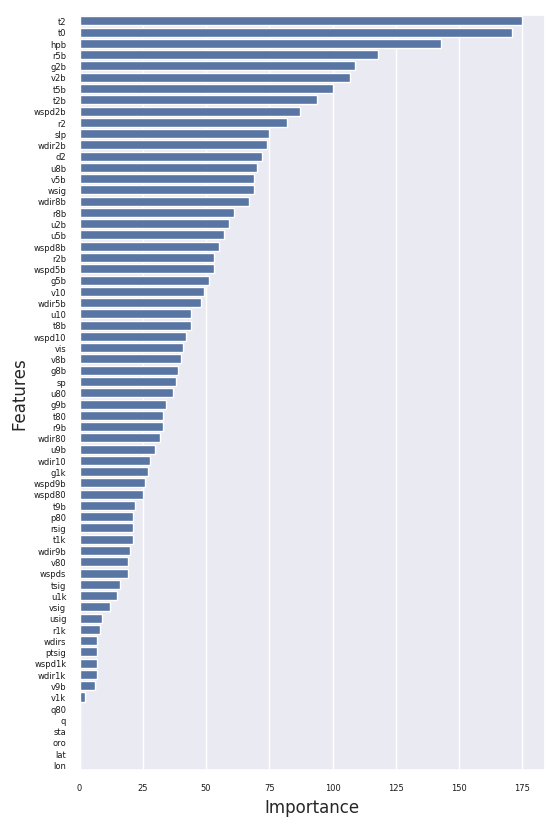

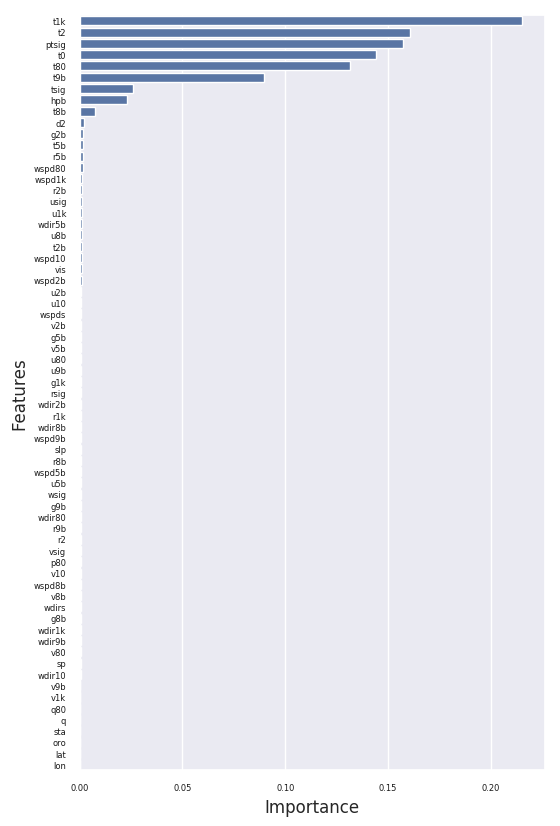

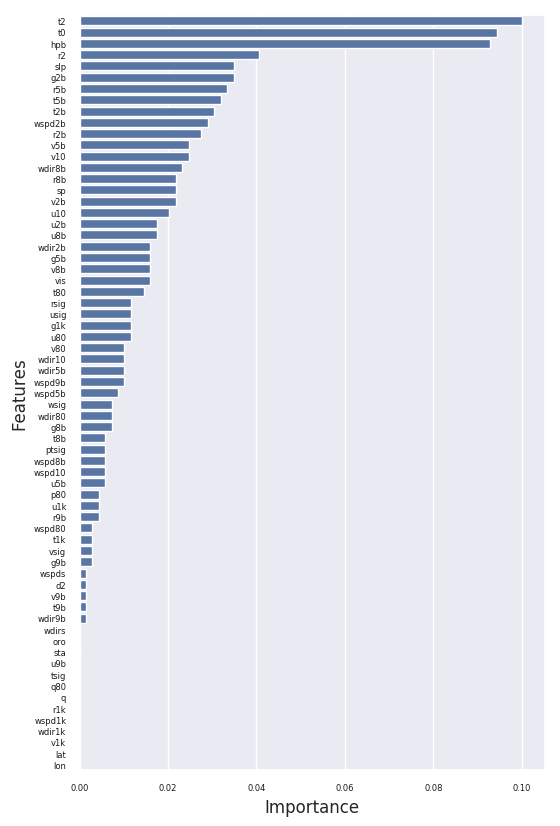

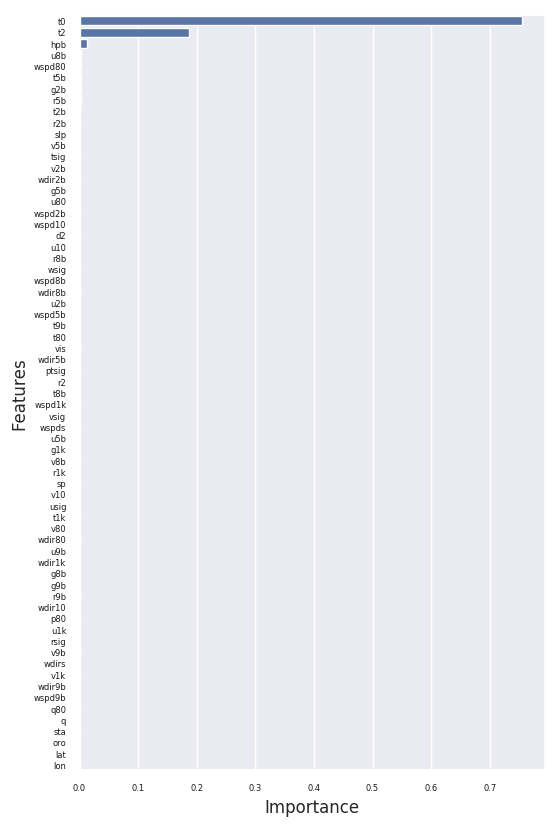

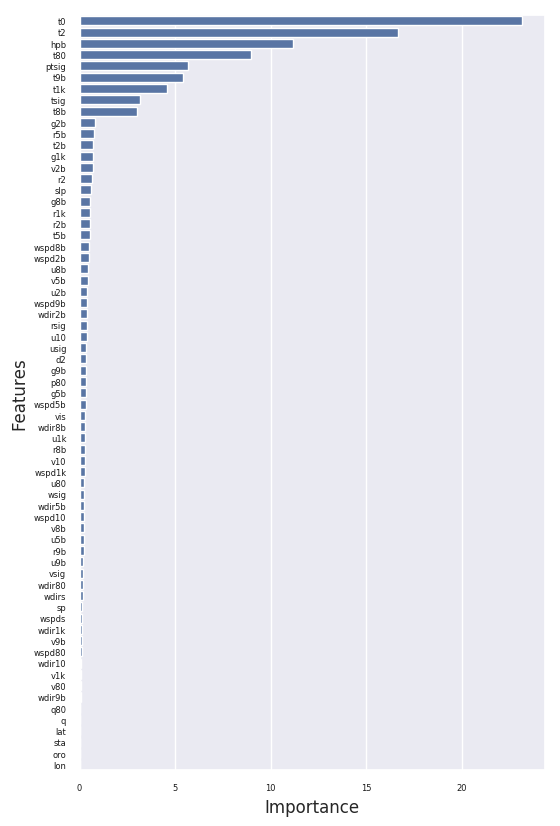

In [10]:
if __name__ == '__main__':
    print(SID_TODO)
    
    dic=train_by_site(train_all=False,baseline=True,target='t2m')
    print(dic)